# Milestone I: Spotify song lyrical impact analysis 
## Data Wrangling, Preprocessing, merging,  EDA
### By: Muhammad Asad Kamran

In [2]:
import polars as pl
import torch
from torch.utils.data import Dataset, DataLoader
import re
from transformers import BertTokenizer, BertModel
from bertopic import BERTopic
from sklearn.feature_extraction.text import TfidfVectorizer
import multiprocessing as mp

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
print(f"Using GPU: {torch.cuda.get_device_name(0)}")

Using GPU: NVIDIA GeForce MX550


# Loading raw datasets

In [5]:
# Load datasets in chunks using pandas
data_path = "./data/merged_data.csv"
data_path_lyrics = "./data/ong_lyrics.csv"

## Preprocessing routine
Can be used for lyrics, title

In [6]:
# Preprocessing function
def preprocess_and_clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove all non-alphabet and non-space characters
        text = re.sub(r'\W+', ' ', text)  # Remove all non-word characters
        text = re.sub(r'\s+', ' ', text)  # Replace all runs of whitespace with a single space
        return text.strip().lower()  # Remove leading and trailing whitespace and convert to lowercase
    else:
        return ''

## Using polars for dataset loading

In [7]:
# Load the songs datasets
spotify_songs = pl.read_csv(data_path)

# Basic exploratory data analysis (EDA) for spotify charts songs

In [8]:
spotify_songs.columns

['',
 'title',
 'rank',
 'date',
 'artist',
 'url',
 'region',
 'chart',
 'trend',
 'streams',
 'track_id',
 'album',
 'popularity',
 'duration_ms',
 'explicit',
 'release_date',
 'available_markets',
 'af_danceability',
 'af_energy',
 'af_key',
 'af_loudness',
 'af_mode',
 'af_speechiness',
 'af_acousticness',
 'af_instrumentalness',
 'af_liveness',
 'af_valence',
 'af_tempo',
 'af_time_signature']

In [9]:
spotify_songs.dtypes

[Int64,
 String,
 Int64,
 String,
 String,
 String,
 String,
 String,
 String,
 Float64,
 String,
 String,
 Float64,
 Float64,
 Boolean,
 String,
 String,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64,
 Float64]

In [10]:
spotify_songs.sample(10)

,title,rank,date,artist,url,region,chart,trend,streams,track_id,album,popularity,duration_ms,explicit,release_date,available_markets,af_danceability,af_energy,af_key,af_loudness,af_mode,af_speechiness,af_acousticness,af_instrumentalness,af_liveness,af_valence,af_tempo,af_time_signature
i64,str,i64,str,str,str,str,str,str,f64,str,str,f64,f64,bool,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
20654491,"""Levikset repee (feat. VilleGal…",137,"""2021-06-26""","""Sini Sabotage""","""https://open.spotify.com/track…","""Finland""","""top200""","""MOVE_DOWN""",8246.0,"""6QmvGtapHbSNolhCzfZGXZ""","""22m²""",50.0,201626.0,false,"""2013-12-05""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.827,0.801,5.0,-5.106,1.0,0.0686,0.0713,0.0,0.0873,0.655,127.992,4.0
23662987,"""Shivers""",12,"""2021-09-25""","""Ed Sheeran""","""https://open.spotify.com/track…","""Slovakia""","""top200""","""SAME_POSITION""",8005.0,"""75MNhvTCCKsST3YqqUiU9r""","""Shivers""",7.0,207853.0,false,"""2021-09-13""","""[]""",0.788,0.859,2.0,-2.724,1.0,0.0856,0.281,0.0,0.0424,0.822,141.02,4.0
22265528,"""Per Ty (feat. Mozzik)""",52,"""2021-11-09""","""Dardan, Nimo""","""https://open.spotify.com/track…","""Germany""","""top200""","""MOVE_DOWN""",127304.0,"""1KwLkHOnyWedxyhZBOIHUM""","""Per Ty (feat. Mozzik)""",52.0,240000.0,true,"""2021-10-14""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.812,0.672,1.0,-6.432,0.0,0.0833,0.0656,0.0000783,0.0759,0.568,130.972,4.0
17629505,"""Circles""",84,"""2020-11-23""","""Post Malone""","""https://open.spotify.com/track…","""Latvia""","""top200""","""NEW_ENTRY""",1201.0,"""21jGcNKet2qwijlDFuPiPb""","""Hollywood's Bleeding""",86.0,215280.0,false,"""2019-09-06""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.695,0.762,0.0,-3.497,1.0,0.0395,0.192,0.00244,0.0863,0.553,120.042,4.0
8360237,"""Youngblood""",186,"""2019-11-16""","""5 Seconds of Summer""","""https://open.spotify.com/track…","""Portugal""","""top200""","""MOVE_DOWN""",4032.0,"""2iUXsYOEPhVqEBwsqP70rE""","""Youngblood (Deluxe)""",82.0,203417.0,false,"""2018-06-15""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.596,0.854,7.0,-5.114,0.0,0.463,0.0169,0.0,0.124,0.152,120.274,4.0
13118788,"""To Kryfto""",35,"""2018-05-24""","""Melisses""","""https://open.spotify.com/track…","""Greece""","""viral50""","""MOVE_UP""",null,"""4XCDaCYXPc0zJZ5ESym31k""","""To Kryfto""",0.0,238050.0,false,"""2018-05-07""","""[]""",0.447,0.379,9.0,-7.891,0.0,0.0298,0.339,0.0,0.117,0.129,129.927,4.0
11548738,"""Me La Avente""",85,"""2020-03-31""","""Carin Leon""","""https://open.spotify.com/track…","""Guatemala""","""top200""","""MOVE_UP""",6493.0,"""2QwMXe5zbqymDZGYsMDVqZ""","""El Malo""",0.0,155802.0,false,"""2019-08-01""","""[]""",0.723,0.48,11.0,-4.1,0.0,0.0326,0.557,0.0,0.0705,0.909,144.533,3.0
9178712,"""Oprah’s Bank Account (Lil Yach…",37,"""2020-04-04""","""Lil Yachty""","""https://open.spotify.com/track…","""United States""","""top200""","""MOVE_UP""",462348.0,"""7wsmIIm0xWmtP7TmACXkJn""","""Oprah’s Bank Account (Lil Yach…",58.0,206702.0,true,"""2020-03-09""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.836,0.617,0.0,-4.363,1.0,0.0534,0.17,0.0,0.319,0.866,138.066,4.0
9165218,"""Pa Olvidarte (feat. Manuel Tur…",181,"""2019-10-28""","""ChocQuibTown, Zion & Lennox, F…","""https://open.spotify.com/track…","""Ecuador""","""top200""","""MOVE_DOWN""",4153.0,"""2ktoFujjJtantyMoVdBJlX""","""Pa Olvidarte (feat. Manuel Tur…",59.0,256417.0,false,"""2019-02-01""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.724,0.791,7.0,-5.411,1.0,0.169,0.0441,0.000007,0.239,0.856,176.011,4.0


In [11]:

print("Number of records / rows in spotify all charts:", spotify_songs.shape[0])
print("Number of metadata / columns in spotify all charts:", spotify_songs.shape[1])

Number of records / rows in spotify all charts: 26174269
Number of metadata / columns in spotify all charts: 29


In [12]:
spotify_songs.describe()

statistic,,title,rank,date,artist,url,region,chart,trend,streams,track_id,album,popularity,duration_ms,explicit,release_date,available_markets,af_danceability,af_energy,af_key,af_loudness,af_mode,af_speechiness,af_acousticness,af_instrumentalness,af_liveness,af_valence,af_tempo,af_time_signature
str,f64,str,f64,str,str,str,str,str,str,f64,str,str,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2.6174269e7,"""26174258""",2.6174269e7,"""26174269""","""26174251""","""26174269""","""26174269""","""26174269""","""26174269""",2.0321961e7,"""25870018""","""25850842""",2.5870018e7,2.5870018e7,2.5870018e7,"""25870018""","""25870018""",2.5870018e7,2.5870018e7,2.5870018e7,2.5870018e7,2.5870018e7,2.5870018e7,2.5870018e7,2.5870018e7,2.5870018e7,2.5870018e7,2.5870018e7,2.5870018e7
"""null_count""",0.0,"""11""",0.0,"""0""","""18""","""0""","""0""","""0""","""0""",5.852308e6,"""304251""","""323427""",304251.0,304251.0,304251.0,"""304251""","""304251""",304251.0,304251.0,304251.0,304251.0,304251.0,304251.0,304251.0,304251.0,304251.0,304251.0,304251.0,304251.0
"""mean""",1.3087134e7,null,80.921906,null,null,null,null,null,null,55261.251042,null,null,46.687974,209290.569384,0.291273,null,null,0.685822,0.643769,5.334744,-6.239387,0.573054,0.109725,0.257403,0.013532,0.169348,0.523052,121.163427,3.967508
"""std""",7.5559e6,null,59.18582,null,null,null,null,null,null,209586.97496,null,null,30.826461,51496.571907,null,null,null,0.137278,0.166601,3.637686,2.514121,0.494634,0.099981,0.246146,0.085494,0.129048,0.222981,29.399339,0.271398
"""min""",0.0,"""!""",1.0,"""2017-01-01""","""!!!""","""https://open.spotify.com/track…","""Andorra""","""top200""","""MOVE_DOWN""",1001.0,"""000RW47rhEkSqjgTrZx7YX""","""!""",0.0,0.0,0.0,"""0000""","""['AD', 'AE', 'AG', 'AL', 'AR',…",0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",6.543567e6,null,29.0,null,null,null,null,null,null,3546.0,null,null,7.0,180950.0,null,null,null,0.601,0.536,2.0,-7.466,0.0,0.0427,0.0563,0.0,0.0934,0.35,97.028,4.0
"""50%""",1.3087134e7,null,67.0,null,null,null,null,null,null,9565.0,null,null,57.0,204466.0,null,null,null,0.704,0.662,6.0,-5.854,1.0,0.0673,0.176,0.0,0.12,0.523,118.611,4.0
"""75%""",1.9630701e7,null,131.0,null,null,null,null,null,null,35409.0,null,null,73.0,230571.0,null,null,null,0.785,0.77,8.0,-4.524,1.0,0.136,0.394,0.0000264,0.197,0.697,140.014,4.0
"""max""",2.6174268e7,"""🪐""",200.0,"""2021-12-31""","""Ｍ, 兩千 2ØØØ, RedcolorG""","""https://open.spotify.com/track…","""Vietnam""","""viral50""","""SAME_POSITION""",1.9749704e7,"""7zzhknA0A39TH81meuX7WA""","""｢untitled｣""",96.0,9.318296e6,1.0,"""2024-03-20""","""[]""",0.988,1.0,11.0,2.24,1.0,0.966,0.996,0.993,0.996,0.999,238.431,5.0


### Features insight for spotify songs

The dataset contains a variety of features, including song title, artist, album, release date, duration, audio features (danceability, energy, key, loudness, etc.), and streaming data (rank, trend, streams). This richness of features allows for various analyses and modeling tasks.

**Audio Features Range**: The audio features, such as danceability, energy, and valence, have values ranging from 0 to 1, which is typical for these normalized features. The loudness feature has a wider range, from around -60 dB to 2.24 dB.

**Categorical Features**: There are several categorical features in the dataset, such as region, chart, trend, and explicit (boolean). These features can be useful for segmenting the data or incorporating them as categorical variables in machine learning models

**Continuous Features**: The dataset also includes continuous features like duration (in milliseconds), popularity, and tempo. These features can be used for regression tasks or as input features for machine learning models

**Time-Series Data**: The presence of the date and release_date columns suggests that the dataset has a time-series component, which can be leveraged for analyzing temporal trends or patterns in music popularity, streaming, or audio features.

**Conclusion**:
Overall, this dataset seems rich and diverse, allowing for various analyses, such as identifying popular music trends, investigating the relationship between audio features and streaming performance, building recommendation systems, or predicting song popularity based on available features.

### Identifying nulls

In [13]:
spotify_songs.null_count()

,title,rank,date,artist,url,region,chart,trend,streams,track_id,album,popularity,duration_ms,explicit,release_date,available_markets,af_danceability,af_energy,af_key,af_loudness,af_mode,af_speechiness,af_acousticness,af_instrumentalness,af_liveness,af_valence,af_tempo,af_time_signature
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,11,0,0,18,0,0,0,0,5852308,304251,323427,304251,304251,304251,304251,304251,304251,304251,304251,304251,304251,304251,304251,304251,304251,304251,304251,304251


### Removing null values for title & artist
This will remove around 29 records where title or artist is null. Since we will join with lyrics (2nd) dataset on basis of title of song and there artist, so we are removing records which have null values for artist & title of songs

In [14]:
# This will remove around 29 records where title or artist is null
spotify_songs = spotify_songs.filter(pl.col('title').is_not_null() | pl.col('artist').is_not_null()) 

In [15]:
spotify_songs.shape # verify records after removing nulls

(26174269, 29)

### Verify about records which have same title & artist with same release date

There are several records / songs which are release in different regions, or part of different charts or trends, so before joining we are doing data manipulation to remove same song being repeated to reduce number of records

In [16]:
### This is a sample song which is repeated
sample_repeat_title_records = spotify_songs.filter(pl.col('title') == "Amandine Insensible")
# Display the filtered DataFrame
sample_repeat_title_records

,title,rank,date,artist,url,region,chart,trend,streams,track_id,album,popularity,duration_ms,explicit,release_date,available_markets,af_danceability,af_energy,af_key,af_loudness,af_mode,af_speechiness,af_acousticness,af_instrumentalness,af_liveness,af_valence,af_tempo,af_time_signature
i64,str,i64,str,str,str,str,str,str,f64,str,str,f64,f64,bool,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
23385390,"""Amandine Insensible""",49,"""2017-04-11""","""Sevdaliza""","""https://open.spotify.com/track…","""Bulgaria""","""viral50""","""NEW_ENTRY""",null,"""2bhrfI4U6lYYDA3pq8Xuyb""","""Children of Silk""",0.0,259793.0,false,"""2015-11-24""","""[]""",0.596,0.323,3.0,-9.952,0.0,0.0352,0.356,0.296,0.15,0.24,133.857,4.0
23427145,"""Amandine Insensible""",39,"""2017-04-12""","""Sevdaliza""","""https://open.spotify.com/track…","""Bulgaria""","""viral50""","""MOVE_UP""",null,"""2bhrfI4U6lYYDA3pq8Xuyb""","""Children of Silk""",0.0,259793.0,false,"""2015-11-24""","""[]""",0.596,0.323,3.0,-9.952,0.0,0.0352,0.356,0.296,0.15,0.24,133.857,4.0


### Identify how many records are repeated based on title, artist & release date
There are around 212870 records which are repeated based on title, artist & release date

In [17]:
# Group by 'title' and 'artist' and count the number of occurrences
title_artist_counts = spotify_songs.group_by(['title', 'artist','release_date']).agg(
    pl.col('title').count().alias('count')
)
title_artist_counts.shape

(212870, 4)

In [18]:
title_artist_counts.sample(10)

title,artist,release_date,count
str,str,str,u32
"""Priecīgus Ziemassvētkus""","""Jorspeis""","""2013-12-01""",3
"""Ausgehen""","""Kex Kuhl, Taha""",null,7
"""Heb Ik Dat Gezegd?""","""Froukje""","""2021-01-07""",64
"""Vtedy Su Vianoce""","""Dara Rolins""","""2009-01-01""",11
"""你說了算""","""A-Mei Chang, E-SO""","""2017-12-11""",128
"""Con la Chota al Hombro!""","""The Party Band""","""2014-07-20""",10
"""French Fries""","""Coma_Cose""","""2017-10-13""",2
"""Life Changes""","""Thomas Rhett""","""2017-09-08""",43
"""American Boy (feat. Kanye West…","""Estelle""","""2008-03-28""",56


### Another sample for repeated songs for title: Big Woman for artist: Nadia Rose

In [19]:
sample_repeat_title_No_1_records = spotify_songs.filter((pl.col('title') == "Big Woman") & (pl.col('artist') == "Nadia Rose")) 
# Display the filtered DataFrame
sample_repeat_title_No_1_records

,title,rank,date,artist,url,region,chart,trend,streams,track_id,album,popularity,duration_ms,explicit,release_date,available_markets,af_danceability,af_energy,af_key,af_loudness,af_mode,af_speechiness,af_acousticness,af_instrumentalness,af_liveness,af_valence,af_tempo,af_time_signature
i64,str,i64,str,str,str,str,str,str,f64,str,str,f64,f64,bool,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
11757772,"""Big Woman""",41,"""2017-11-01""","""Nadia Rose""","""https://open.spotify.com/track…","""Ireland""","""viral50""","""MOVE_UP""",null,"""7fCUcN7kE2wJNnjgC6iG7V""","""Big Woman""",14.0,207184.0,true,"""2017-10-27""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.738,0.924,7.0,-4.249,1.0,0.238,0.152,0.0,0.42,0.795,105.963,4.0
11759075,"""Big Woman""",42,"""2017-11-01""","""Nadia Rose""","""https://open.spotify.com/track…","""United Kingdom""","""viral50""","""MOVE_UP""",null,"""7fCUcN7kE2wJNnjgC6iG7V""","""Big Woman""",14.0,207184.0,true,"""2017-10-27""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.738,0.924,7.0,-4.249,1.0,0.238,0.152,0.0,0.42,0.795,105.963,4.0
11771629,"""Big Woman""",40,"""2017-11-02""","""Nadia Rose""","""https://open.spotify.com/track…","""Ireland""","""viral50""","""MOVE_UP""",null,"""7fCUcN7kE2wJNnjgC6iG7V""","""Big Woman""",14.0,207184.0,true,"""2017-10-27""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.738,0.924,7.0,-4.249,1.0,0.238,0.152,0.0,0.42,0.795,105.963,4.0
11774716,"""Big Woman""",41,"""2017-11-02""","""Nadia Rose""","""https://open.spotify.com/track…","""United Kingdom""","""viral50""","""MOVE_UP""",null,"""7fCUcN7kE2wJNnjgC6iG7V""","""Big Woman""",14.0,207184.0,true,"""2017-10-27""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.738,0.924,7.0,-4.249,1.0,0.238,0.152,0.0,0.42,0.795,105.963,4.0
12850334,"""Big Woman""",47,"""2017-10-30""","""Nadia Rose""","""https://open.spotify.com/track…","""Ireland""","""viral50""","""NEW_ENTRY""",null,"""7fCUcN7kE2wJNnjgC6iG7V""","""Big Woman""",14.0,207184.0,true,"""2017-10-27""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.738,0.924,7.0,-4.249,1.0,0.238,0.152,0.0,0.42,0.795,105.963,4.0
12873267,"""Big Woman""",44,"""2017-10-30""","""Nadia Rose""","""https://open.spotify.com/track…","""United Kingdom""","""viral50""","""NEW_ENTRY""",null,"""7fCUcN7kE2wJNnjgC6iG7V""","""Big Woman""",14.0,207184.0,true,"""2017-10-27""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.738,0.924,7.0,-4.249,1.0,0.238,0.152,0.0,0.42,0.795,105.963,4.0
12878739,"""Big Woman""",49,"""2017-10-31""","""Nadia Rose""","""https://open.spotify.com/track…","""Ireland""","""viral50""","""MOVE_DOWN""",null,"""7fCUcN7kE2wJNnjgC6iG7V""","""Big Woman""",14.0,207184.0,true,"""2017-10-27""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.738,0.924,7.0,-4.249,1.0,0.238,0.152,0.0,0.42,0.795,105.963,4.0
12887769,"""Big Woman""",49,"""2017-10-31""","""Nadia Rose""","""https://open.spotify.com/track…","""United Kingdom""","""viral50""","""MOVE_DOWN""",null,"""7fCUcN7kE2wJNnjgC6iG7V""","""Big Woman""",14.0,207184.0,true,"""2017-10-27""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.738,0.924,7.0,-4.249,1.0,0.238,0.152,0.0,0.42,0.795,105.963,4.0


### To identify how many a song is repeated

In [20]:
title_artist_release_date_counts = (
    spotify_songs
    .group_by(['title', 'artist', 'release_date'])
    .agg(pl.len().alias('count'))
    .filter(pl.col('count') > 1)
)

In [21]:
title_artist_release_date_counts.shape

(186365, 4)

In [22]:
title_artist_release_date_counts.sample(10)

title,artist,release_date,count
str,str,str,u32
"""Extra""","""Manillio, Nativ""","""2017-12-15""",6
"""New York (Hollywood Hills) [Va…","""Maija Vilkkumaa""","""2019-10-18""",29
"""A Mi Manera""","""Siempre Asi""","""2001-09-20""",7
"""Stay Blessed""","""Bryson Tiller""","""2017-05-26""",22
"""Personne""","""Bigflo & Oli""","""2017-06-23""",139
"""KJFH""","""Jardo SK""","""2021-10-13""",23
"""Håll i dig""","""Adel, Armin""","""2018-10-26""",33
"""Gotta Get It Right""","""Vanilla Ninja""","""2021-06-18""",6
"""Tiempo de Vernos""","""Maldy, J Alvarez, Plan B""","""2019-01-11""",21


### Unique songs based on title, artist & release date

In [23]:
# Check the unique combinations of title, artist, and release_date
unique_combinations = spotify_songs.select(['title', 'artist', 'release_date']).unique()
print("Number of unique combinations of title, artist, and release_date:", unique_combinations.shape[0])

# Check the original shape
print("Original shape of the dataset:", spotify_songs.shape)

Number of unique combinations of title, artist, and release_date: 212870
Original shape of the dataset: (26174269, 29)


In [24]:
# Group by title, artist, and release_date to count duplicates
title_artist_counts = spotify_songs.group_by(['title', 'artist', 'release_date']).agg(
    pl.col('title').count().alias('count')
)

# Filter only the duplicates (count > 1)
duplicate_counts = title_artist_counts.filter(pl.col('count') > 1)
print("Number of duplicate records:", duplicate_counts.shape[0])

Number of duplicate records: 186364


### Remove duplicates record based on title, artist


In [25]:
# Remove duplicate rows based on 'title', 'artist', and 'release_date'
spotify_songs_unique = spotify_songs.unique(subset=['title', 'artist'], keep='first',maintain_order=True)

# Check the shape after removing duplicates
print("Shape after removing duplicates:", spotify_songs_unique.shape)

Shape after removing duplicates: (197535, 29)


In [26]:
spotify_songs_unique.shape

(197535, 29)

In [27]:
# Compare the unique combinations after removing duplicates
unique_combinations_after = spotify_songs_unique.select(['title', 'artist', 'release_date']).unique()
print("Number of unique combinations after removing duplicates:", unique_combinations_after.shape[0])

# Ensure that no additional records are removed mistakenly
#assert unique_combinations.shape[0] == unique_combinations_after.shape[0], "Mismatch in unique combinations before and after removing duplicates"


Number of unique combinations after removing duplicates: 197535


In [28]:
spotify_songs_unique.sample(10)

,title,rank,date,artist,url,region,chart,trend,streams,track_id,album,popularity,duration_ms,explicit,release_date,available_markets,af_danceability,af_energy,af_key,af_loudness,af_mode,af_speechiness,af_acousticness,af_instrumentalness,af_liveness,af_valence,af_tempo,af_time_signature
i64,str,i64,str,str,str,str,str,str,f64,str,str,f64,f64,bool,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
7147436,"""誰も知らない""",100,"""2019-11-04""","""ARASHI""","""https://open.spotify.com/track…","""Japan""","""top200""","""NEW_ENTRY""",23412.0,"""1ep3vnJjjHqXySMAYro0kN""","""誰も知らない""",32.0,242145.0,false,"""2014-05-28""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.539,0.926,7.0,-3.136,0.0,0.0716,0.324,0.0,0.117,0.583,141.966,4.0
18837541,"""I Believe - (Video / Radio Mix…",44,"""2020-12-21""","""Bro'Sis""","""https://open.spotify.com/track…","""Austria""","""viral50""","""NEW_ENTRY""",null,"""0zhtzi9L84aUC1p2BxPQmc""","""Never Forget (Where You Come F…",1.0,207346.0,false,"""2002-01-21""","""[]""",0.574,0.621,0.0,-7.107,1.0,0.115,0.172,0.0,0.341,0.676,195.901,4.0
24314262,"""Come loro""",38,"""2017-06-19""","""Eiemgei, Barlow""","""https://open.spotify.com/track…","""Italy""","""viral50""","""NEW_ENTRY""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
23402647,"""Rockets (feat. Moe Moks)""",45,"""2017-04-11""","""LION BABE""","""https://open.spotify.com/track…","""Denmark""","""viral50""","""NEW_ENTRY""",null,"""5LWKsMeXaYBoKzCHk8syQy""","""Rockets (feat. Moe Moks)""",47.0,217386.0,false,"""2017-02-07""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.677,0.658,8.0,-5.149,1.0,0.0699,0.15,0.0,0.155,0.874,134.086,4.0
23313227,"""Pendaison de crémaillère""",30,"""2017-04-07""","""Orloge Simard""","""https://open.spotify.com/track…","""Canada""","""viral50""","""NEW_ENTRY""",null,"""3eH79UcsE2CpLSG8FlH1xP""","""Pendaison de crémaillère - Sin…",0.0,421298.0,false,"""2017-03-31""","""[]""",0.567,0.66,7.0,-4.905,1.0,0.0334,0.681,0.0,0.111,0.449,151.921,4.0
23267374,"""Versace On The Floor""",47,"""2017-04-04""","""Joseph Vincent""","""https://open.spotify.com/track…","""Malaysia""","""viral50""","""NEW_ENTRY""",null,"""1KalIfAR9lEpLWZZFdEfW4""","""Versace On The Floor""",0.0,138201.0,false,"""2017-01-03""","""[]""",0.536,0.0403,7.0,-13.507,1.0,0.0462,0.89,0.0,0.127,0.521,175.734,4.0
10438319,"""Doppelte Elefanten""",198,"""2019-12-27""","""TaxKiller""","""https://open.spotify.com/track…","""Israel""","""top200""","""NEW_ENTRY""",2496.0,"""14OrJ0bh9WhIdBU4FEjwlZ""","""Doppelte Elefanten""",0.0,449280.0,false,"""2019-01-25""","""[]""",0.74,0.676,2.0,-7.9,1.0,0.0353,0.000896,0.923,0.106,0.394,124.987,4.0
12586978,"""Avalanche""",50,"""2018-02-12""","""Bring Me The Horizon""","""https://open.spotify.com/track…","""Andorra""","""viral50""","""NEW_ENTRY""",null,"""4p2F2oqLIONeQwpGpyBox8""","""That's The Spirit (Track by Tr…",0.0,262026.0,false,"""2015-09-04""","""[]""",0.41,0.931,7.0,-4.084,0.0,0.0704,0.0000268,0.00616,0.112,0.317,160.048,4.0
17322898,"""Summer Tights""",72,"""2021-07-23""","""DPR LIVE""","""https://open.spotify.com/track…","""South Korea""","""top200""","""NEW_ENTRY""",2608.0,"""6KeIkgoC8SUeJ4VPw5Lkx8""","""IITE COOL""",52.0,214813.0,false,"""2021-07-23""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.832,0.64,6.0,-6.853,0.0,0.082,0.504,0.0,0.0871,0.846,119.915,4.0


## Converting release date to datetime
Saving the release date as datetime format in release_date_dt column. This is although not require for merging, but for data wrangling to get more feature or data insight based on time series.

In [29]:
spotify_songs_unique.null_count()

,title,rank,date,artist,url,region,chart,trend,streams,track_id,album,popularity,duration_ms,explicit,release_date,available_markets,af_danceability,af_energy,af_key,af_loudness,af_mode,af_speechiness,af_acousticness,af_instrumentalness,af_liveness,af_valence,af_tempo,af_time_signature
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,1,0,0,1,0,0,0,0,97314,17987,18290,17987,17987,17987,17987,17987,17987,17987,17987,17987,17987,17987,17987,17987,17987,17987,17987,17987


In [30]:
spotify_songs_unique = spotify_songs_unique.with_columns(
    pl.col('release_date').str.strptime(pl.Datetime, format="%Y-%m-%d", strict=False).alias('release_date_dt')
)

In [31]:
spotify_songs_unique.sample(5)

,title,rank,date,artist,url,region,chart,trend,streams,track_id,album,popularity,duration_ms,explicit,release_date,available_markets,af_danceability,af_energy,af_key,af_loudness,af_mode,af_speechiness,af_acousticness,af_instrumentalness,af_liveness,af_valence,af_tempo,af_time_signature,release_date_dt
i64,str,i64,str,str,str,str,str,str,f64,str,str,f64,f64,bool,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[μs]
9438020,"""Halellujah (Cover)""",36,"""2020-01-17""","""Mata""","""https://open.spotify.com/track…","""Poland""","""top200""","""NEW_ENTRY""",49843.0,"""41gjsrLFhiuIph9dMCnbeL""","""100 dni do matury""",31.0,94613.0,false,"""2020-01-17""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.312,0.196,7.0,-11.666,1.0,0.0427,0.941,0.0,0.254,0.421,200.667,3.0,2020-01-17 00:00:00
21712275,"""Rinse & Repeat""",48,"""2017-01-14""","""Riton, Kah-Lo""","""https://open.spotify.com/track…","""Latvia""","""viral50""","""NEW_ENTRY""",null,"""5GGqtZRxGpMre6RQO5LQqC""","""Rinse & Repeat""",38.0,151229.0,true,"""2016-02-19""","""['AU', 'NZ']""",0.789,0.736,1.0,-6.534,1.0,0.0587,0.0343,0.00353,0.16,0.599,121.997,4.0,2016-02-19 00:00:00
12105144,"""Erste Wahl""",47,"""2017-10-04""","""GLORIA""","""https://open.spotify.com/track…","""Switzerland""","""viral50""","""NEW_ENTRY""",null,"""36ETScuTKzSgb6r9VhPC6F""","""Erste Wahl""",0.0,219946.0,false,"""2017-09-29""","""[]""",0.778,0.638,6.0,-6.281,0.0,0.0346,0.114,0.000775,0.0705,0.67,121.988,4.0,2017-09-29 00:00:00
23844195,"""Pilot""",166,"""2021-10-25""","""NCT 127""","""https://open.spotify.com/track…","""Malaysia""","""top200""","""NEW_ENTRY""",8095.0,"""5JelBxGOmT607wiyQG6fxK""","""Favorite - The 3rd Album Repac…",42.0,209360.0,false,"""2021-10-25""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.624,0.879,5.0,-2.676,0.0,0.0552,0.0579,0.0,0.223,0.762,160.024,4.0,2021-10-25 00:00:00
21573170,"""热爱105°C的你 (治愈女生版)""",109,"""2021-11-01""","""予笙""","""https://open.spotify.com/track…","""Singapore""","""top200""","""MOVE_UP""",7685.0,"""6KB7K6OvTRdsTjROP84kLl""","""热爱105°C的你 (治愈女生版)""",0.0,195418.0,false,"""2021-06-07""","""[]""",0.826,0.474,10.0,-9.696,1.0,0.0808,0.255,0.0,0.0759,0.744,137.075,4.0,2021-06-07 00:00:00


### Calendar heatmap for number of songs released each month

In [32]:
spotify_songs_unique_notnull_release_date = spotify_songs_unique.filter(pl.col('release_date').is_not_null())

In [33]:
spotify_songs_unique_notnull_release_date.shape

(179548, 30)

In [34]:
# Extract year and month from the release date
spotify_songs_unique_notnull_release_date = spotify_songs_unique_notnull_release_date.with_columns(    
    pl.col('release_date_dt').dt.year().alias('release_year'),    
    pl.col('release_date_dt').dt.month().alias('release_month')
)

In [35]:
spotify_songs_unique_notnull_release_date.sample(5)

,title,rank,date,artist,url,region,chart,trend,streams,track_id,album,popularity,duration_ms,explicit,release_date,available_markets,af_danceability,af_energy,af_key,af_loudness,af_mode,af_speechiness,af_acousticness,af_instrumentalness,af_liveness,af_valence,af_tempo,af_time_signature,release_date_dt,release_year,release_month
i64,str,i64,str,str,str,str,str,str,f64,str,str,f64,f64,bool,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[μs],i32,i8
13878850,"""Bakit""",6,"""2019-05-06""","""Nobrvnd, Alisson Shore""","""https://open.spotify.com/track…","""Philippines""","""viral50""","""NEW_ENTRY""",null,"""3NXZSXLpOCqgHRBrYdk6t3""","""Bakit""",25.0,240065.0,true,"""2019-04-13""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.708,0.473,7.0,-8.926,0.0,0.0766,0.627,0.0,0.0849,0.617,117.029,4.0,2019-04-13 00:00:00,2019,4
11733984,"""不明下落""",37,"""2017-10-01""","""Guo Ding""","""https://open.spotify.com/track…","""Taiwan""","""viral50""","""MOVE_UP""",null,"""6GZJ5VY3K67iMb6KTPuUZh""","""不明下落""",22.0,253543.0,false,"""2017-09-22""","""['TO', 'WS', 'FJ', 'KI', 'MH',…",0.504,0.684,11.0,-7.237,0.0,0.0442,0.533,0.0689,0.169,0.335,119.994,4.0,2017-09-22 00:00:00,2017,9
13235531,"""Nehaj Ju Odísť""",42,"""2018-07-20""","""Čis T, Yzomandias""","""https://open.spotify.com/track…","""Slovakia""","""viral50""","""NEW_ENTRY""",null,"""66eBmhxb01ERxrxmrpERqs""","""Yak Orol""",0.0,249440.0,true,"""2018-06-28""","""[]""",0.776,0.563,1.0,-7.086,0.0,0.148,0.186,0.0,0.38,0.0416,103.953,4.0,2018-06-28 00:00:00,2018,6
6811571,"""Beni Bana Yar Etmezler""",99,"""2019-09-06""","""Şanışer""","""https://open.spotify.com/track…","""Turkey""","""top200""","""NEW_ENTRY""",29899.0,"""0ujQU6ecPOJMuBRpFhAuMG""","""LUDOVICO II""",0.0,211000.0,false,"""2018-04-13""","""[]""",0.568,0.463,11.0,-13.274,0.0,0.0802,0.416,0.0,0.0752,0.37,162.076,4.0,2018-04-13 00:00:00,2018,4
18614546,"""From The Bottom""",60,"""2021-04-11""","""Kkay The Artist""","""https://open.spotify.com/track…","""Lithuania""","""top200""","""NEW_ENTRY""",2716.0,"""6y291m8M6DeNA3qllNLlet""","""From The Bottom""",0.0,185051.0,true,"""2021-03-15""","""[]""",0.619,0.565,6.0,-7.377,0.0,0.57,0.102,0.0,0.102,0.579,96.144,4.0,2021-03-15 00:00:00,2021,3


In [36]:
spotify_songs_unique = spotify_songs_unique.with_columns([
    pl.col('release_date_dt').dt.year().alias('release_year'),
    pl.col('release_date_dt').dt.month().alias('release_month')
])

### Calendar heatmap generic function for song count, popularity, duration_ms, and streams

In [37]:
import altair as alt
def create_calendar_heatmap_chart(data, for_column, tooltip_label, title=None):
    chart = (
        alt.Chart(data)
        .mark_rect(stroke="white", strokeWidth=2)
        .encode(
            alt.X(
                "release_month:O",
                title='Release Month',
            ),
            alt.Y(
                "release_year:O",
                sort="descending",
                title='Release Year',
            ),
            alt.Color(
                f"{for_column}:Q",
                legend=alt.Legend(),
                title=title,
                scale=alt.Scale(
                    range=[
                        "RGBA(140,107,254,0.15)",
                        "RGBA(140,107,254,1)",
                        "RGBA(154,232,255,1)",
                    ]
                ),
            ),
            tooltip=[f"{for_column}:Q"],
        )
        .configure_view(strokeWidth=0)
        .configure_axis(labelFontSize=12)
        .properties(width="container", height=120)
    )
    return chart

## For song count

In [38]:
spotify_songs_grouped_songCount = spotify_songs_unique.group_by(['release_year', 'release_month']).agg(
    pl.count('release_month').alias('song_count')
)

### converting to pandas
As altair support pandas dataframe for its charts

In [39]:
spotify_songs_grouped_songCount_pandas = spotify_songs_grouped_songCount.to_pandas()

In [40]:
# Filter the DataFrame to include only the years from 2015 and later
spotify_songs_grouped_songCount_pandas_filtered = spotify_songs_grouped_songCount_pandas[spotify_songs_grouped_songCount_pandas['release_year'] >= 2015]

print(spotify_songs_grouped_songCount_pandas_filtered.head())


    release_year  release_month  song_count
10        2016.0            4.0         406
14        2020.0            5.0        2895
19        2019.0            6.0        2551
21        2021.0            6.0        1948
27        2020.0           11.0        2602


In [41]:
song_count_chart = create_calendar_heatmap_chart(spotify_songs_grouped_songCount_pandas_filtered, 'song_count', 'song_count', 'Song Count')
song_count_chart.display()

alt.Chart(...)

The insight we got is highest number of songs from 2015 onwards are released either in month of march or b/w august & november

## For Popularity

In [42]:
spotify_songs_grouped_popularity = spotify_songs_unique.group_by(['release_year', 'release_month']).agg(
    pl.max('popularity').alias('max_popularity')
)

In [43]:
spotify_songs_grouped_popularity_pandas = spotify_songs_grouped_popularity.to_pandas()

In [44]:
# Filter the DataFrame to include only the years from 2015 and later
spotify_songs_grouped_popularity_pandas_filtered = spotify_songs_grouped_popularity_pandas[spotify_songs_grouped_popularity_pandas['release_year'] >= 2015]

print(spotify_songs_grouped_popularity_pandas_filtered.head())

    release_year  release_month  max_popularity
4         2019.0            7.0            81.0
19        2019.0            9.0            86.0
22        2018.0            2.0            87.0
33        2018.0            5.0            84.0
35        2021.0            5.0            86.0


In [45]:
max_popularity_chart = create_calendar_heatmap_chart(spotify_songs_grouped_popularity_pandas_filtered, 'max_popularity', 'max_popularity', 'Max Popularity')
max_popularity_chart.display()

alt.Chart(...)

Again most popular songs as per popularity column are release in month of march or from october to december

## For duration_ms

In [46]:
spotify_songs_grouped_duration = spotify_songs_unique.group_by(['release_year', 'release_month']).agg(
    pl.max('duration_ms').alias('max_duration')
)

In [47]:
spotify_songs_grouped_duration_pandas = spotify_songs_grouped_duration.to_pandas()

In [48]:
# Filter the DataFrame to include only the years from 2015 and later
spotify_songs_grouped_duration_pandas_filtered = spotify_songs_grouped_duration_pandas[spotify_songs_grouped_duration_pandas['release_year'] >= 2015]

print(spotify_songs_grouped_duration_pandas_filtered.head())

    release_year  release_month  max_duration
12        2018.0           10.0      622161.0
16        2016.0            2.0      666500.0
36        2021.0            3.0      615775.0
41        2017.0           10.0     3447799.0
61        2018.0           11.0      653626.0


In [49]:
max_duration_chart = create_calendar_heatmap_chart(spotify_songs_grouped_duration_pandas_filtered, 'max_duration', 'max_duration', 'Max Duration')
max_duration_chart.display()

alt.Chart(...)

Recent years have lowest duration of songs. Is it co-related to attention span of user which is reducing in recent years?

## For stream_count

In [50]:
spotify_songs_grouped_stream = spotify_songs_unique.group_by(['release_year', 'release_month']).agg(
    pl.max('streams').alias('max_streams')
)

In [51]:
spotify_songs_grouped_stream_pandas = spotify_songs_grouped_stream.to_pandas()

In [52]:
# Filter the DataFrame to include only the years from 2015 and later
spotify_songs_grouped_stream_pandas_filtered = spotify_songs_grouped_stream_pandas[spotify_songs_grouped_stream_pandas['release_year'] >= 2015]

print(spotify_songs_grouped_stream_pandas_filtered.head())

    release_year  release_month  max_streams
8         2022.0           12.0          NaN
21        2018.0            6.0     693102.0
22        2020.0            8.0     420430.0
33        2020.0            2.0     856986.0
50        2021.0            4.0     753163.0


In [53]:
max_streams_chart = create_calendar_heatmap_chart(spotify_songs_grouped_stream_pandas_filtered, 'max_streams', 'max_streams', 'Max Streams')
max_streams_chart.display()

alt.Chart(...)

2021 has highest streams of songs. Is it co-related to covid lock down, where user have more time to listen to spotify songs?

# Basic exploratory data analysis (EDA) for lyrics dataset

## Loading Lyrics dataset

In [54]:
# Load the lyrics dataset
lyrics = pl.read_csv(data_path_lyrics)


In [55]:
# Check the shape after removing duplicates
print("Shape of lyrics dataset:", lyrics.shape)

print("Columns in lyrics dataset:", lyrics.columns)

print("Data types in lyrics dataset:", lyrics.dtypes)

Shape of lyrics dataset: (5134856, 11)
Columns in lyrics dataset: ['title', 'tag', 'artist', 'year', 'views', 'features', 'lyrics', 'id', 'language_cld3', 'language_ft', 'language']
Data types in lyrics dataset: [String, String, String, Int64, Int64, String, String, Int64, String, String, String]


In [56]:
lyrics.sample(10)

title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
str,str,str,i64,i64,str,str,i64,str,str,str
"""Movin On""","""rb""","""Shara Nelson""",1995,49,"""{}""","""Don't blame me, you know I tri…",3200268,"""en""","""en""","""en"""
"""New life feat. annie williams""","""pop""","""Grits""",2015,590,"""{}""","""My life be like Ooh Aah (yeah)…",1942598,"""en""","""en""","""en"""
"""​dance with me""","""rap""","""SEBii""",2019,157,"""{​d1v}""","""[Intro] I survive Take that [?…",5527368,"""en""","""en""","""en"""
"""Rocket Ride""","""pop""","""Pink Cream 69""",1998,57,"""{}""","""Heard your mother she answered…",1117007,"""en""","""en""","""en"""
"""Не ссы Cover""","""pop""","""Moskaev""",2019,276,"""{}""","""[Verse 1] И мы убегаем с тобой…",5044928,"""ru""","""ru""","""ru"""
"""Make Them Die Slowly""","""rock""","""Slasher Dimension""",2017,24,"""{}""","""They were cold sadistic killer…",3614452,"""en""","""en""","""en"""
"""WINGS""","""rap""","""Ufo361""",2021,15518,"""{}""","""[Songtext zu „WINGS“] [Hook] …",6218879,"""de""","""de""","""de"""
"""Psalm 10""","""misc""","""Holy Bible (KJV)""",2017,35,"""{}""","""Psalms 10:1: Why standest tho…",115440,"""en""","""en""","""en"""
"""East Side""","""rock""","""Sky Swamp Orange""",2018,44,"""{}""","""Verse 1: Momma always told me …",3432414,"""en""","""en""","""en"""


In [57]:
lyrics.describe()

statistic,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
str,str,str,str,f64,f64,str,str,f64,str,str,str
"""count""","""5134691""","""5134856""","""5134856""",5.134856e6,5.134856e6,"""5134856""","""5134856""",5.134856e6,"""5043890""","""5000534""","""4907938"""
"""null_count""","""165""","""0""","""0""",0.0,0.0,"""0""","""0""",0.0,"""90966""","""134322""","""226918"""
"""mean""",null,null,null,2010.303073,3060.939181,null,null,3.8301e6,null,null,null
"""std""",null,null,null,45.011921,47309.800698,null,null,2.3057e6,null,null,null
"""min""","""LAVIE""","""country""",""" (LAYER, Sayo, Saya, M…",1.0,0.0,"""{!SAURA}""",""" Date Artist Location …",1.0,"""af""","""af""","""af"""
"""25%""",null,null,null,2009.0,22.0,null,null,1.62522e6,null,null,null
"""50%""",null,null,null,2016.0,85.0,null,null,3.866619e6,null,null,null
"""75%""",null,null,null,2019.0,448.0,null,null,5.820614e6,null,null,null
"""max""","""󠀡​youtalk_ALOT""","""rock""","""avamlmAv""",2100.0,2.3351415e7,"""{🚀👑ASTROWORLD}""","""󾆐 Watch, Ah Now... Mi And You …",7.882848e6,"""zu""","""zh""","""zh"""


Following is basic feature insight:

**Views Range**: The views column ranges from 0 to 23,351,415, indicating a large variation in the number of views or plays for different songs.

**Year Range**: The year column ranges from 1 to 2100, suggesting that the dataset has missing or not accurate year representation

**Multilingual**: The presence of language detection columns suggests that the dataset contains lyrics in multiple languages, which could be useful for language-specific analysis or cross-language studies.

**Conclusion**: 
Overall, this lyrics dataset seems diverse and comprehensive, providing opportunities for various analyses, such as studying lyrical trends over time, exploring the relationship between lyrics and popularity (views), language-specific lyrical analysis, or building language models for lyrics generation or translation

In [58]:
lyrics.null_count()

title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
165,0,0,0,0,0,0,0,90966,134322,226918


### Filtering for english songs only before merging

In [59]:
print("Shape of lyrics dataset before filtering for English songs:", lyrics.shape)

lyrics_filter_en = lyrics.filter((pl.col('language_cld3') == "en") & (pl.col('language_ft') == "en"))

print("Shape of lyrics dataset after filtering for English songs:", lyrics_filter_en.shape)

Shape of lyrics dataset before filtering for English songs: (5134856, 11)
Shape of lyrics dataset after filtering for English songs: (3374198, 11)


In [60]:
# Group by title, artist, and release_date to count duplicates
title_artist_lyrics_en_counts = lyrics_filter_en.group_by(['title', 'artist']).agg(
    pl.col('title').count().alias('count')
)

# Filter only the duplicates (count > 1)
duplicate_title_artist_lyrics_en_counts = title_artist_lyrics_en_counts.filter(pl.col('count') > 1)
print("Number of duplicate records:", duplicate_title_artist_lyrics_en_counts.shape[0])

Number of duplicate records: 10


### Removing duplicates based on title of song & artist

In [61]:
print("Shape of lyrics dataset before removing duplicates:", lyrics_filter_en.shape)

lyrics_filter_en_unique = lyrics_filter_en.unique(subset=['title', 'artist'], keep='first',maintain_order=True)

print("Shape of lyrics dataset after removing duplicates:", lyrics_filter_en_unique.shape)

Shape of lyrics dataset before removing duplicates: (3374198, 11)
Shape of lyrics dataset after removing duplicates: (3374188, 11)


# Merge the two datasets

In [62]:
# Merge the two datasets on 'title' and 'artist'
merged_lyrics_with_spotify_songs_data = spotify_songs_unique.join(lyrics_filter_en_unique, on=['title', 'artist'], how='inner')

print("Shape of merged dataset:", merged_lyrics_with_spotify_songs_data.shape)

Shape of merged dataset: (21743, 41)


In [63]:
merged_lyrics_with_spotify_songs_data.sample(10)

,title,rank,date,artist,url,region,chart,trend,streams,track_id,album,popularity,duration_ms,explicit,release_date,available_markets,af_danceability,af_energy,af_key,af_loudness,af_mode,af_speechiness,af_acousticness,af_instrumentalness,af_liveness,af_valence,af_tempo,af_time_signature,release_date_dt,release_year,release_month,tag,year,views,features,lyrics,id,language_cld3,language_ft,language
i64,str,i64,str,str,str,str,str,str,f64,str,str,f64,f64,bool,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[μs],i32,i8,str,i64,i64,str,str,i64,str,str,str
12265685,"""No Witness""",48,"""2017-12-09""","""LP""","""https://open.spotify.com/track…","""Latvia""","""viral50""","""NEW_ENTRY""",null,"""13qy3gxJFjx5IKXrW7t6dj""","""Lost on You""",0.0,208257.0,false,"""2016-12-09""","""[]""",0.59,0.765,5.0,-6.012,1.0,0.036,0.136,0.0,0.0991,0.453,78.519,4.0,2016-12-09 00:00:00,2016,12,"""pop""",2016,52036,"""{}""","""[Verse 1] How do I get you out…",2944047,"""en""","""en""","""en"""
1944504,"""Almost Love""",136,"""2018-06-08""","""Sabrina Carpenter""","""https://open.spotify.com/track…","""Belgium""","""top200""","""NEW_ENTRY""",4991.0,"""1349a1cfv3J1bb0qGch29z""","""Almost Love""",0.0,212371.0,false,"""2018-06-06""","""[]""",0.81,0.759,9.0,-3.029,0.0,0.0376,0.111,0.000005,0.0919,0.615,104.993,4.0,2018-06-06 00:00:00,2018,6,"""pop""",2018,81540,"""{}""","""[Intro] Ah yeah, yeah, yeah […",3716668,"""en""","""en""","""en"""
19931429,"""Finesse""",12,"""2020-05-04""","""Bryson Tiller""","""https://open.spotify.com/track…","""Australia""","""viral50""","""NEW_ENTRY""",null,"""4VjGRnrVnqy5eN45aokIzT""","""Finesse""",0.0,166741.0,false,"""2020-03-24""","""[]""",0.736,0.336,1.0,-10.592,1.0,0.161,0.128,0.0,0.122,0.534,108.695,4.0,2020-03-24 00:00:00,2020,3,"""rb""",2018,145764,"""{}""","""[Intro] Yeah, wow They not rea…",3951414,"""en""","""en""","""en"""
11835387,"""Florets""",50,"""2017-11-08""","""Grace VanderWaal""","""https://open.spotify.com/track…","""Brazil""","""viral50""","""NEW_ENTRY""",null,"""0nHFy6NhdXegDdokhXrTw0""","""Just The Beginning""",35.0,225933.0,false,"""2017-11-03""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.67,0.705,3.0,-5.573,0.0,0.126,0.182,0.0000208,0.101,0.67,116.052,4.0,2017-11-03 00:00:00,2017,11,"""pop""",2017,19350,"""{}""","""[Intro] Wherever the wind blow…",3235958,"""en""","""en""","""en"""
12686168,"""Bruises""",17,"""2017-10-23""","""Tim Freitag""","""https://open.spotify.com/track…","""Switzerland""","""viral50""","""NEW_ENTRY""",null,"""2RkgLLqVNjddix8D6fO9q5""","""Bruises""",0.0,209343.0,false,"""2017-10-20""","""[]""",0.671,0.601,2.0,-5.979,1.0,0.0316,0.129,0.000375,0.11,0.247,137.061,4.0,2017-10-20 00:00:00,2017,10,"""rock""",2017,22,"""{}""","""[Verse 1] I got bruises I got …",4955472,"""en""","""en""","""en"""
13400455,"""Part of Me""",31,"""2018-10-20""","""Good Old War""","""https://open.spotify.com/track…","""Czech Republic""","""viral50""","""NEW_ENTRY""",null,"""7aG1xKK3cdvg7JUKaECwJ4""","""Part of Me""",0.0,182640.0,false,"""2017-09-01""","""[]""",0.407,0.417,8.0,-4.9,1.0,0.0282,0.818,0.0,0.106,0.335,157.06,4.0,2017-09-01 00:00:00,2017,9,"""pop""",2017,12464,"""{}""","""We've got to run If you're hol…",3167422,"""en""","""en""","""en"""
11059994,"""Man of War""",170,"""2017-07-01""","""Radiohead""","""https://open.spotify.com/track…","""Japan""","""top200""","""NEW_ENTRY""",2160.0,"""552BIJ9kKwwqiGf4YojYbL""","""OK Computer OKNOTOK 1997 2017""",0.0,269093.0,false,"""2017-06-23""","""[]""",0.274,0.472,9.0,-7.614,0.0,0.0263,0.0131,0.069,0.0802,0.14,148.996,4.0,2017-06-23 00:00:00,2017,6,"""rock""",2017,131961,"""{}""","""[Verse 1] Drift all you like f…",1573507,"""en""","""en""","""en"""
12390990,"""Is There Still Time?""",13,"""2018-03-12""","""The Coronas""","""https://open.spotify.com/track…","""Ireland""","""viral50""","""NEW_ENTRY""",null,"""6kxtW3MFGubBizM1o0NvjZ""","""Is There Still Time?""",0.0,201216.0,false,"""2018-03-06""","""[]""",0.408,0.469,11.0,-8.542,0.0,0.039,0.451,0.0000

In [64]:
# Check the shape after removing duplicates
print("Shape of merged dataset:", merged_lyrics_with_spotify_songs_data.shape)

print("Columns in merged dataset:", merged_lyrics_with_spotify_songs_data.columns)

print("Data types in merged dataset:", merged_lyrics_with_spotify_songs_data.dtypes)

Shape of merged dataset: (21743, 41)
Columns in merged dataset: ['', 'title', 'rank', 'date', 'artist', 'url', 'region', 'chart', 'trend', 'streams', 'track_id', 'album', 'popularity', 'duration_ms', 'explicit', 'release_date', 'available_markets', 'af_danceability', 'af_energy', 'af_key', 'af_loudness', 'af_mode', 'af_speechiness', 'af_acousticness', 'af_instrumentalness', 'af_liveness', 'af_valence', 'af_tempo', 'af_time_signature', 'release_date_dt', 'release_year', 'release_month', 'tag', 'year', 'views', 'features', 'lyrics', 'id', 'language_cld3', 'language_ft', 'language']
Data types in merged dataset: [Int64, String, Int64, String, String, String, String, String, String, Float64, String, String, Float64, Float64, Boolean, String, String, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Datetime(time_unit='us', time_zone=None), Int32, Int8, String, Int64, Int64, String, String, Int64, String, String, String]


In [65]:
merged_lyrics_with_spotify_songs_data.describe()

statistic,,title,rank,date,artist,url,region,chart,trend,streams,track_id,album,popularity,duration_ms,explicit,release_date,available_markets,af_danceability,af_energy,af_key,af_loudness,af_mode,af_speechiness,af_acousticness,af_instrumentalness,af_liveness,af_valence,af_tempo,af_time_signature,release_date_dt,release_year,release_month,tag,year,views,features,lyrics,id,language_cld3,language_ft,language
str,f64,str,f64,str,str,str,str,str,str,f64,str,str,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,str,f64,f64,str,str,f64,str,str,str
"""count""",21743.0,"""21743""",21743.0,"""21743""","""21743""","""21743""","""21743""","""21743""","""21743""",8967.0,"""19680""","""19678""",19680.0,19680.0,19680.0,"""19680""","""19680""",19680.0,19680.0,19680.0,19680.0,19680.0,19680.0,19680.0,19680.0,19680.0,19680.0,19680.0,19680.0,"""19037""",19037.0,19037.0,"""21743""",21743.0,21743.0,"""21743""","""21743""",21743.0,"""21743""","""21743""","""21743"""
"""null_count""",0.0,"""0""",0.0,"""0""","""0""","""0""","""0""","""0""","""0""",12776.0,"""2063""","""2065""",2063.0,2063.0,2063.0,"""2063""","""2063""",2063.0,2063.0,2063.0,2063.0,2063.0,2063.0,2063.0,2063.0,2063.0,2063.0,2063.0,2063.0,"""2706""",2706.0,2706.0,"""0""",0.0,0.0,"""0""","""0""",0.0,"""0""","""0""","""0"""
"""mean""",1.2961e7,null,75.453341,null,null,null,null,null,null,43443.811866,null,null,25.516311,216569.154116,0.254878,null,null,0.610193,0.624367,5.247917,-7.25514,0.603049,0.098416,0.247076,0.044003,0.174412,0.455249,120.767377,3.945681,"""2016-03-16 22:20:09.140095""",2015.736671,6.206965,null,2014.559812,111613.125328,null,null,3.5570e6,null,null,null
"""std""",8.2821e6,null,57.929425,null,null,null,null,null,null,76573.285676,null,null,25.369285,58609.689676,null,null,null,0.156537,0.201064,3.598246,2.955288,0.489278,0.105041,0.275549,0.150382,0.13213,0.224861,28.748713,0.33685,null,7.519439,3.488752,null,16.751313,401721.216584,null,null,1.8383e6,null,null,null
"""min""",24.0,""".""",1.0,"""2017-01-01""","""""Weird Al"" Yankovic""","""https://open.spotify.com/track…","""Andorra""","""top200""","""MOVE_DOWN""",1001.0,"""003eoIwxETJujVWmNFMoZy""","""!""",0.0,0.0,0.0,"""0000""","""['AD', 'AE', 'AG', 'AR', 'AT',…",0.0866,0.00543,0.0,-34.475,0.0,0.0222,0.0,0.0,0.0154,0.0313,34.099,0.0,"""1945-01-01 00:00:00""",1945.0,1.0,"""country""",1.0,0.0,"""{""10 / 000 Maniacs""}""","""""Are you working? What kind of…",28.0,"""en""","""en""","""en"""
"""25%""",5.740777e6,null,36.0,null,null,null,null,null,null,5259.0,null,null,0.0,182693.0,null,null,null,0.505,0.489,2.0,-8.738,0.0,0.0363,0.023,0.0,0.0965,0.279,98.033,4.0,"""2017-01-27 00:00:00""",2017.0,3.0,null,2016.0,2714.0,null,null,2.924913e6,null,null,null
"""50%""",1.2850776e7,null,47.0,null,null,null,null,null,null,18076.0,null,null,22.0,208770.0,null,null,null,0.618,0.635,5.0,-6.737,1.0,0.0528,0.13,0.000008,0.121,0.44,119.961,4.0,"""2018-02-10 00:00:00""",2018.0,6.0,null,2017.0,14997.0,null,null,3.509764e6,null,null,null
"""75%""",2.1015439e7,null,123.0,null,null,null,null,null,null,43521.0,null,null,47.0,239283.0,null,null,null,0.724,0.776,8.0,-5.209,1.0,0.107,0.404,0.00148,0.207,0.619,139.995,4.0,"""2019-06-21 00:00:00""",2019.0,9.0,null,2019.0,71296.0,null,null,4.734169e6,null,null,null
"""max""",2.6172374e7,"""四 Claudia""",200.0,"""2021-12-31""","""yaeow""","""https://open.spotify.com/track…","""Vietnam""","""viral50""","""SAME_POSITION""",1.367372e6,"""7zxhhMt0j1JV7OuFpQ2Boe""","""金桔希子""",96.0,934582.0,1.0,"""2021-12-17""","""[]""",0.983,1.0,11.0,1.023,1.0,0.954,0.995,0.99,0.988,0.992,220.099,5.0,"""2021-12-17 00:00:00""",2021.0,12.0,"""rock""",2022.0,1.7575634e7,"""{‎Birthh}""","""何がリアル 何がリアルじゃ無いか What's real a…",7.877934e6,"""en""","""en""","""en"""


### Preprocessed and clean title, artist & lyrics 

In [66]:
# Use preprocess_and_clean_text function to clean title, artist, and lyrics
merged_lyrics_with_spotify_songs_data = merged_lyrics_with_spotify_songs_data.with_columns(
    merged_lyrics_with_spotify_songs_data['title'].map_elements(preprocess_and_clean_text,return_dtype=pl.String).alias('cleaned_title'),
    merged_lyrics_with_spotify_songs_data['artist'].map_elements(preprocess_and_clean_text,return_dtype=pl.String).alias('cleaned_artist'),
    merged_lyrics_with_spotify_songs_data['lyrics'].map_elements(preprocess_and_clean_text,return_dtype=pl.String).alias('cleaned_lyrics')
)

In [67]:
merged_lyrics_with_spotify_songs_data.sample(10)

,title,rank,date,artist,url,region,chart,trend,streams,track_id,album,popularity,duration_ms,explicit,release_date,available_markets,af_danceability,af_energy,af_key,af_loudness,af_mode,af_speechiness,af_acousticness,af_instrumentalness,af_liveness,af_valence,af_tempo,af_time_signature,release_date_dt,release_year,release_month,tag,year,views,features,lyrics,id,language_cld3,language_ft,language,cleaned_title,cleaned_artist,cleaned_lyrics
i64,str,i64,str,str,str,str,str,str,f64,str,str,f64,f64,bool,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[μs],i32,i8,str,i64,i64,str,str,i64,str,str,str,str,str,str
24520740,"""No Love""",49,"""2017-07-30""","""Kevin Gates""","""https://open.spotify.com/track…","""Switzerland""","""viral50""","""NEW_ENTRY""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""rap""",2017,71606,"""{}""","""[Pre-Chorus] What a hell of a …",3165153,"""en""","""en""","""en""","""no love""","""kevin gates""","""prechorus what a hell of a fee…"
12339022,"""You Worry Me""",34,"""2018-01-15""","""Nathaniel Rateliff & The Night…","""https://open.spotify.com/track…","""Belgium""","""viral50""","""NEW_ENTRY""",null,"""0gqxf8wrEkewjmZB7OT4mL""","""You Worry Me""",0.0,214160.0,false,"""2018-01-10""","""[]""",0.665,0.639,2.0,-7.747,1.0,0.0276,0.121,0.327,0.0952,0.642,100.082,4.0,2018-01-10 00:00:00,2018,1,"""rock""",2018,113259,"""{}""","""[Verse 1] I'm alright today Yo…",3427900,"""en""","""en""","""en""","""you worry me""","""nathaniel rateliff the night s…","""verse im alright today you gon…"
21244056,"""Tokyo Drift""",39,"""2017-01-01""","""Tommy Cash""","""https://open.spotify.com/track…","""Estonia""","""viral50""","""NEW_ENTRY""",null,"""4e9LOZy3t7X2wPP4I3od3J""","""Euroz Dollaz Yeniz""",0.0,141714.0,true,"""2014-11-01""","""[]""",0.837,0.636,8.0,-11.61,1.0,0.219,0.0299,0.000302,0.591,0.303,110.032,4.0,2014-11-01 00:00:00,2014,11,"""rap""",2014,6631,"""{}""","""[Intro] Ah, ah, push it Ah, ah…",2952120,"""en""","""en""","""en""","""tokyo drift""","""tommy cash""","""intro ah ah push it ah ah push…"
25766,"""No Excuses""",195,"""2018-03-02""","""Meghan Trainor""","""https://open.spotify.com/track…","""Belgium""","""top200""","""NEW_ENTRY""",3597.0,"""7fCNUWi6uflDTQ08srxMZk""","""No Excuses""",54.0,152862.0,false,"""2018-03-01""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.827,0.658,6.0,-3.846,1.0,0.0517,0.0224,0.0,0.0417,0.523,115.016,4.0,2018-03-01 00:00:00,2018,3,"""pop""",2018,154287,"""{}""","""[Intro] Woo Huh [Verse 1] Wha…",3468495,"""en""","""en""","""en""","""no excuses""","""meghan trainor""","""intro woo huh verse what you s…"
632176,"""Broken Arrows""",32,"""2018-05-01""","""Avicii""","""https://open.spotify.com/track…","""Sweden""","""top200""","""MOVE_DOWN""",53677.0,"""2BVVmJQZv4fOPWavI9mkIj""","""Stories""",0.0,232760.0,false,"""2015-10-02""","""[]""",0.634,0.674,7.0,-7.145,1.0,0.0465,0.0487,0.00116,0.102,0.298,115.995,4.0,2015-10-02 00:00:00,2015,10,"""pop""",2015,199880,"""{}""","""[Verse 1] You stripped your lo…",2159609,"""en""","""en""","""en""","""broken arrows""","""avicii""","""verse you stripped your love d…"
12153435,"""Glad You Came""",47,"""2017-12-04""","""AREA21""","""https://open.spotify.com/track…","""Australia""","""viral50""","""NEW_ENTRY""",null,"""7xHfguzndSR2jOpMxzqh3r""","""Glad You Came""",43.0,152583.0,false,"""2017-12-01""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.655,0.804,8.0,-5.288,1.0,0.0798,0.0605,0.000535,0.381,0.399,104.95,4.0,2017-12-01 00:00:00,2017,12,"""rap""",2017,33701,"""{}""","""[Hook] I'm so glad you came, d…",3044507,"""en""","""en""","""en""","""glad you came""","""area""","""hook im so glad you came dont …"
11634325,"""No Friend""",164,"""2017-05-12""","""Paramore""","""https://open.spotify.com/track…","""United Kingdom""","""top200""","""NEW_ENTRY""",52751.0,"""6RaLExL28RxCmQNUnDvUFT""","""After Laughter""",46.0,203773.0,false,"""2017-05-12""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.58

In [68]:
merged_lyrics_with_spotify_songs_data.head(5)

,title,rank,date,artist,url,region,chart,trend,streams,track_id,album,popularity,duration_ms,explicit,release_date,available_markets,af_danceability,af_energy,af_key,af_loudness,af_mode,af_speechiness,af_acousticness,af_instrumentalness,af_liveness,af_valence,af_tempo,af_time_signature,release_date_dt,release_year,release_month,tag,year,views,features,lyrics,id,language_cld3,language_ft,language,cleaned_title,cleaned_artist,cleaned_lyrics
i64,str,i64,str,str,str,str,str,str,f64,str,str,f64,f64,bool,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[μs],i32,i8,str,i64,i64,str,str,i64,str,str,str,str,str,str
283351,"""C.R.E.A.M.""",48,"""2017-08-19""","""Wu-Tang Clan""","""https://open.spotify.com/track…","""Luxembourg""","""viral50""","""NEW_ENTRY""",null,"""119c93MHjrDLJTApCVGpvx""","""Enter The Wu-Tang (36 Chambers…",75.0,252026.0,true,"""1993-11-09""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.479,0.549,11.0,-10.551,0.0,0.373,0.57,0.0235,0.127,0.576,180.985,4.0,1993-11-09 00:00:00,1993,11,"""rap""",1994,1984638,"""{}""","""[Produced by RZA] [Intro: Rae…",28,"""en""","""en""","""en""","""cream""","""wutang clan""","""produced by rza intro raekwon …"
4068624,"""A Milli""",145,"""2018-09-28""","""Lil Wayne""","""https://open.spotify.com/track…","""United States""","""top200""","""NEW_ENTRY""",290548.0,"""6ScJMrlpiLfZUGtWp4QIVt""","""Tha Carter III""",70.0,221840.0,true,"""2008-06-10""","""['AR', 'AT', 'BE', 'BO', 'BR',…",0.674,0.695,6.0,-8.636,0.0,0.278,0.0387,0.00202,0.194,0.773,151.486,4.0,2008-06-10 00:00:00,2008,6,"""rap""",2008,1237174,"""{}""","""[Intro] Bangladesh Young Money…",59,"""en""","""en""","""en""","""a milli""","""lil wayne""","""intro bangladesh young money y…"
1165617,"""My Name Is""",124,"""2018-05-10""","""Eminem""","""https://open.spotify.com/track…","""Ireland""","""top200""","""NEW_ENTRY""",5924.0,"""0l08dcPEqNEUhymVBext8h""","""The Slim Shady LP""",0.0,268400.0,true,"""1999-01-01""","""[]""",0.833,0.681,5.0,-6.248,0.0,0.356,0.0406,0.0,0.0926,0.839,85.497,4.0,1999-01-01 00:00:00,1999,1,"""rap""",1999,1464039,"""{}""","""[Produced by Dr. Dre] [Chorus…",68,"""en""","""en""","""en""","""my name is""","""eminem""","""produced by dr dre chorus emin…"
11756317,"""I Wish""",37,"""2017-11-01""","""Skee-Lo""","""https://open.spotify.com/track…","""Andorra""","""viral50""","""MOVE_DOWN""",null,"""3LklW07tvdx2AHsgfi1Mng""","""I Wish""",65.0,249293.0,false,"""1995-09-02""","""['CA', 'US']""",0.669,0.809,7.0,-7.146,1.0,0.147,0.00137,0.0,0.38,0.572,97.885,4.0,1995-09-02 00:00:00,1995,9,"""rap""",1995,459740,"""{}""","""[Intro] Hey, this is radio sta…",154,"""en""","""en""","""en""","""i wish""","""skeelo""","""intro hey this is radio statio…"
19232369,"""Beam Me Up Scotty""",174,"""2021-05-14""","""Nicki Minaj""","""https://open.spotify.com/track…","""South Africa""","""top200""","""NEW_ENTRY""",3557.0,"""0f381U8m0oFfGKeIhEJk9J""","""Beam Me Up Scotty""",41.0,238733.0,true,"""2021-05-14""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.691,0.622,4.0,-8.544,0.0,0.168,0.000337,0.00103,0.256,0.604,96.122,4.0,2021-05-14 00:00:00,2021,5,"""rap""",2008,147230,"""{}""","""[Intro: Nicki Minaj] You know …",229,"""en""","""en""","""en""","""beam me up scotty""","""nicki minaj""","""intro nicki minaj you know the…"


In [155]:
merged_lyrics_with_spotify_songs_data.columns

['',
 'title',
 'rank',
 'date',
 'artist',
 'url',
 'region',
 'chart',
 'trend',
 'streams',
 'track_id',
 'album',
 'popularity',
 'duration_ms',
 'explicit',
 'release_date',
 'available_markets',
 'af_danceability',
 'af_energy',
 'af_key',
 'af_loudness',
 'af_mode',
 'af_speechiness',
 'af_acousticness',
 'af_instrumentalness',
 'af_liveness',
 'af_valence',
 'af_tempo',
 'af_time_signature',
 'release_date_dt',
 'release_year',
 'release_month',
 'tag',
 'year',
 'views',
 'features',
 'lyrics',
 'id',
 'language_cld3',
 'language_ft',
 'language',
 'cleaned_title',
 'cleaned_artist',
 'cleaned_lyrics']

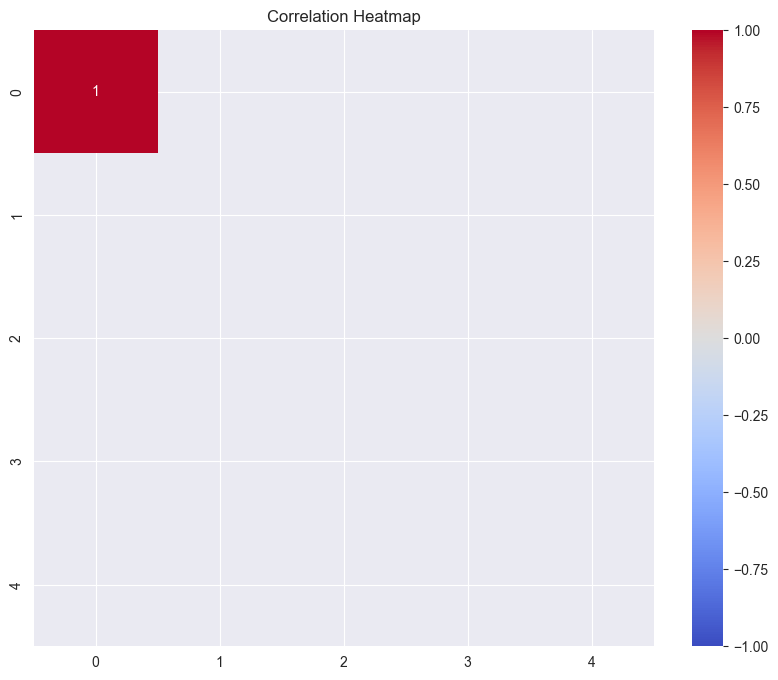

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
# Filter the DataFrame to include only numeric columns
numeric_features = ['views', 'af_energy', 'streams', 'duration_ms', 'af_danceability']
df_filtered_numeric = merged_lyrics_with_spotify_songs_data.select(numeric_features)

# Handle missing values by filling them with the mean of the column
df_filled = df_filtered_numeric.with_columns(
    pl.when(pl.col("streams").is_null()).then(pl.col("streams").mean()).otherwise(pl.col("streams")).alias("streams")
)

# Convert to a Pandas DataFrame
df_filtered_numeric_pd = df_filled.to_pandas()


# Compute the correlation matrix
correlation_matrix = df_filtered_numeric.corr()

# Generate the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Analytical reasoning & answering business questions

**Basic concepts for NLP using LDA & BERT**:

* Token: An individual word or a subword in a text document. In our case in cleaned_lyrics
* Document: A collection of tokens that form a single unit of text, such as a song lyrics
* Corpus: A collection of documents, such as all the song lyrics in our dataset
* Topic: A collection of words that represent a theme or concept in the corpus
* Topic Modeling: The process of automatically identifying topics in a corpus based on the distribution of words in the documents
* Latent Dirichlet Allocation (LDA): A popular topic modeling technique that assumes each document is a mixture of topics and each topic is a mixture of words
* BERTopic: A topic modeling technique that leverages BERT embeddings to identify topics in a corpus
* TF-IDF: Term Frequency-Inverse Document Frequency, a technique for converting text data into numerical features based on word frequencies
* BERT Embeddings: High-dimensional vector representations of text data generated by pre-trained BERT models
* Stop Words: Common words that are often removed from text data during preprocessing, such as "the," "and," "is," etc.
* Bag of Words: A simple representation of text data that ignores word order and only considers word frequencies
* Tokenization: The process of splitting text data into tokens or words
* Vectorization: The process of converting text data into numerical vectors for machine learning models
* Dimensionality Reduction: Techniques for reducing the number of features in a dataset, such as PCA or LDA
* Classification: The process of predicting a category or label for a given input, such as predicting song popularity based on lyrics
* Regression: The process of predicting a continuous value for a given input, such as predicting song duration based on lyrics


![LDA illustration](lda.png)

In [69]:
docs_raw=merged_lyrics_with_spotify_songs_data['cleaned_lyrics'].to_list()

In [70]:
from sklearn.feature_extraction.text import CountVectorizer
# CountVectorizer for LDA, create a DTM (Document Term Matrix) where each entry represents the count of word in document
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(docs_raw)
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)

In [71]:
from sklearn.decomposition import LatentDirichletAllocation

# for TF DTM (document term matrix) created using CountVectorizer
# This model captures raw frequency of terms in documents
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(dtm_tf)

# for lda model to be fitted on DTM creating using TfidfVectorizer, this model captures the importance of terms in documents based on their frequency
# Where DTM represents  term frequency inverse document frequency (TF-IDF) of a word in document / lyrics
# TF-IDF is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents, gives higher weight to words that appear less frequently in the corpus
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=20, random_state=0)

In [72]:
from __future__ import print_function
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

pyLDAvis.lda_model.prepare(lda_tf, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.229356  0.023791       1        1  17.575318
19     0.024479 -0.171599       2        1   8.831287
2     -0.127897 -0.093078       3        1   8.060106
12    -0.163873  0.025203       4        1   7.177894
0      0.157627  0.037795       5        1   5.770024
13    -0.026127 -0.163511       6        1   5.453367
9     -0.157054  0.030982       7        1   4.900879
7     -0.098147  0.004065       8        1   4.413474
4     -0.036942  0.171206       9        1   4.224572
18    -0.052236 -0.025788      10        1   4.037385
10    -0.100644  0.090311      11        1   3.997533
6     -0.034847 -0.155166      12        1   3.752475
1     -0.048965  0.006475      13        1   3.501924
16    -0.030635 -0.102209      14        1   3.471645
5     -0.087280  0.186653      15        1   2.995582
14     0.131000 -0.029409      16        1   2.590017
15     0.044233  0.066494      17        1   2.463806
11     0.112474 -0.038943      18        1   2.443482
3      0.189380  0.026734      19        1   2.411037
8      0.076096  0.109994      20        1   1.928192, topic_info=            Term          Freq         Total Category  logprob  loglift
5095        love  40098.000000  40098.000000  Default  30.0000  30.0000
9514       wanna  21701.000000  21701.000000  Default  29.0000  29.0000
5926         ooh  11686.000000  11686.000000  Default  28.0000  28.0000
9881        yeah  46408.000000  46408.000000  Default  27.0000  27.0000
3704       gonna  12457.000000  12457.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
6471  postchorus    238.620174   4066.130986  Topic20  -5.4184   1.1130
5989       outro    201.460914   8163.960800  Topic20  -5.5877   0.2467
1031      bridge    204.635738   9715.338378  Topic20  -5.5720   0.0884
1737        come    206.048081  16601.481896  Topic20  -5.5652  -0.4406
9881        yeah    213.959171  46408.654218  Topic20  -5.5275  -1.4309

[1465 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0        15  0.994325      aaah
14        8  0.897464    abroad
14       19  0.066479    abroad
16        8  0.959674  absolute
20        1  0.033554  abstract
...     ...       ...       ...
9937      1  0.013468      zach
9937      7  0.969680      zach
9938     14  0.990718      zayn
9943      2  0.802614      zion
9943     17  0.189709      zion

[10011 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 20, 3, 13, 1, 14, 10, 8, 5, 19, 11, 7, 2, 17, 6, 15, 16, 12, 4, 9])

In [132]:
# Number of words per topic
num_words = 10

# For LDA with CountVectorizer
all_lda_lyrics_topics_words_tf = []
for idx, topic in enumerate(lda_tf.components_):
    words = [tf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-num_words - 1:-1]]
    all_lda_lyrics_topics_words_tf.append(words)
    print(f"Topic {idx}: {', '.join(words)}")

Topic 0: man, bad, got, big, aint, people, real, thats, mad, girl
Topic 1: night, tonight, lets, christmas, baby, going, hold, come, right, dance
Topic 2: feel, ive, think, time, cause, make, wont, lie, thought, prechorus
Topic 3: gonna, everybody, girls, alright, rock, got, bring, yeah, gon, whos
Topic 4: world, round, shake, boys, town, cold, heaven, mmm, theres, sing
Topic 5: better, day, lord, lay, gold, turn, follow, walk, woman, king
Topic 6: love, baby, dance, heart, need, want, yeah, make, yes, fall
Topic 7: tell, life, home, believe, dream, days, youre, river, wonder, think
Topic 8: ooh, running, burn, gotta, coming, oohooh, cool, hot, high, closer
Topic 9: let, ill, light, head, wont, hold, break, close, heart, come
Topic 10: shes, live, forever, die, look, lonely, eyes, whoa, dead, higher
Topic 11: run, money, thing, miss, got, really, falling, want, beat, thats
Topic 12: away, hey, long, ill, time, heart, wait, gone, far, youll
Topic 13: yeah, youre, time, baby, mind, body,

In [133]:
# For LDA with TfidfVectorizer
all_lda_lyrics_topics_words_tfidf = []
for idx, topic in enumerate(lda_tfidf.components_):
    words = [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-num_words - 1:-1]]
    all_lda_lyrics_topics_words_tfidf.append(words)
    print(f"Topic {idx}: {', '.join(words)}")

Topic 0: aha, jade, daniel, leighanne, perrie, american, yeh, america, jonah, que
Topic 1: christmas, merry, year, snow, lala, santa, bells, anthony, tree, mistletoe
Topic 2: ahah, bam, hideaway, amor, forevers, justin, atomic, ricochet, mina, lovesick
Topic 3: lovely, sleigh, jingle, legends, ayo, hail, weather, hmmm, sexy, ride
Topic 4: wonderland, bum, oohooh, blossom, sha, chills, alice, winter, dum, julia
Topic 5: nanana, nana, nananana, ooooooh, lay, hol, revolution, nanananana, nananananana, isolation
Topic 6: jesus, born, king, lord, holy, glory, christ, heavenly, hallelujah, arrow
Topic 7: dodo, valentine, woohoo, ahooh, whoaoh, dododo, saves, ooooo, barcelona, tribe
Topic 8: luke, calum, ego, limbo, lakes, louie, rollercoaster, ohwhoa, san, ally
Topic 9: mercy, ohohohohoh, alien, sos, compares, unconditional, gal, phantom, metal, yesterdays
Topic 10: dey, gimme, dada, dadadada, sigh, wooh, wicked, aaah, oohoh, fresh
Topic 11: chester, bennington, shinoda, noah, mike, sarah, j

In [134]:
# Example of how to transform the documents to topic distributions
topic_distributions = lda_tfidf.transform(dtm_tfidf)

### Classification: The process of predicting a category or label for a given input, such as predicting song popularity based on lyrics

In [151]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

# Extract the target variables
popularity_labels = merged_lyrics_with_spotify_songs_data['popularity']
song_durations = merged_lyrics_with_spotify_songs_data['duration_ms']

# Check for NaN values and remove corresponding rows from the dataset
valid_indices = (~popularity_labels.is_null()) & (~song_durations.is_null())
filtered_df = merged_lyrics_with_spotify_songs_data.filter(valid_indices)

# Convert to numpy arrays
popularity_labels = filtered_df['popularity'].to_numpy()
song_durations = filtered_df['duration_ms'].to_numpy()

# Generate the document-term matrix from the filtered data
docs_raw_filtered = filtered_df['cleaned_lyrics'].to_list()  
dtm_tf_filtered = tf_vectorizer.fit_transform(docs_raw_filtered)

# Obtain the topic distributions from the filtered data
topic_distributions_filtered = lda_tfidf.fit_transform(dtm_tf_filtered)

# Ensure the number of samples match in both features and target
assert topic_distributions_filtered.shape[0] == len(popularity_labels)

#topic_distributions = topic_distributions[valid_indices]

# Classification Example
X_train, X_test, y_train, y_test = train_test_split(topic_distributions_filtered, popularity_labels, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Classification Accuracy:", accuracy_score(y_test, y_pred))




Classification Accuracy: 0.3752540650406504


**Basic conclusion**:
The classification accuracy of 0.3752540650406504 indicates that the Random Forest classifier correctly predicted the popularity labels for approximately 37.5% of the test samples. While this accuracy might seem low, it's important to consider the complexity of predicting song popularity based on lyrics alone and the potential imbalance in the dataset. 

If we have time, further analysis and model tuning could potentially improve the classification performance.

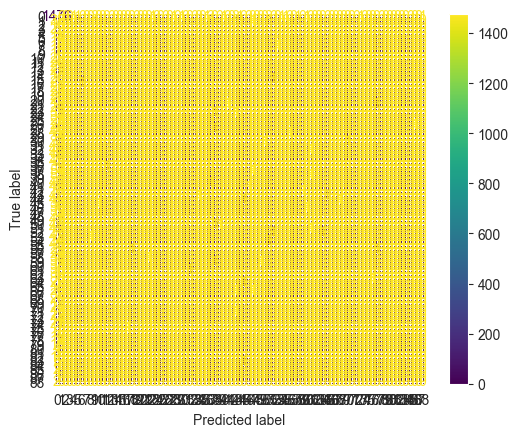

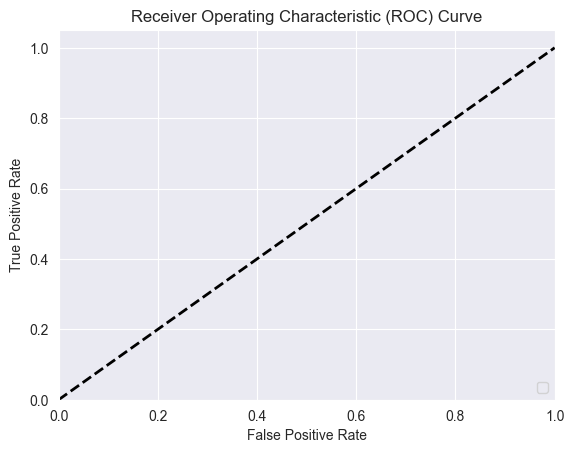

In [153]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import numpy as np
from sklearn.preprocessing import label_binarize

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))
n_classes = y_test_binarized.shape[1]

# Get prediction probabilities
y_prob = clf.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    #roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_prob[:, i])

# Plot ROC curve
plt.figure()
#for i in range(n_classes):
    #plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Regression: The process of predicting a continuous value for a given input, such as predicting song duration based on lyrics

In [154]:
# Regression Example
X_train, X_test, y_train, y_test = train_test_split(topic_distributions_filtered, song_durations, test_size=0.2, random_state=42)
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("Regression Mean Squared Error:", mean_squared_error(y_test, y_pred))

Regression Mean Squared Error: 3045078124.376432


**Basic conclusion**:
* This value indicates the average squared difference between the actual and predicted song durations in milliseconds.
* A high MSE value suggests that the predictions are far from the actual values. In this case, the value 3045078124.376432 is quite large, indicating that the model's predictions are not very accurate.
* It's important to note that the scale of MSE depends on the scale of the target variable. Since song durations are typically in milliseconds, large values for MSE can be expected if the model predictions are significantly off.

# Topic Modeling using BERTopic

In [162]:
# Topic Modeling using BERTopic
topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2")
topics, _ = topic_model.fit_transform(docs_raw)

In [163]:
# Visualize the topics
topic_model.visualize_topics()

In [164]:
topic_info = topic_model.get_topic_info()
print(topic_info)

   Topic  Count                               Name  \
0     -1      8       -1_heavenly_holy_sleep_night   
1      0  21377                    0_you_the_to_me   
2      1    233          1_christmas_the_and_santa   
3      2     43           2_jingle_sleigh_the_bell   
4      3     40                3_harry_you_na_zayn   
5      4     26  4_bennington_chester_shinoda_mike   
6      5     16               5_jonas_nick_joe_you   

                                      Representation  \
0  [heavenly, holy, sleep, night, peace, silent, ...   
1        [you, the, to, me, and, my, it, in, im, on]   
2  [christmas, the, and, santa, merry, to, you, y...   
3  [jingle, sleigh, the, bell, wonderland, bells,...   
4  [harry, you, na, zayn, liam, all, me, the, and...   
5  [bennington, chester, shinoda, mike, the, to, ...   
6  [jonas, nick, joe, you, strangers, me, and, ti...   

                                 Representative_Docs  
0  [silent night holy night all is calm all is br...  
1  [chor

In [165]:
topic_model.visualize_barchart()

In [166]:
topic_model.visualize_heatmap()

In [167]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,8,-1_heavenly_holy_sleep_night,"[heavenly, holy, sleep, night, peace, silent, ...",[silent night holy night all is calm all is br...
1,0,21377,0_you_the_to_me,"[you, the, to, me, and, my, it, in, im, on]",[chorus be with the one who love you this vade...
2,1,233,1_christmas_the_and_santa,"[christmas, the, and, santa, merry, to, you, y...",[verse hang all the mistletoe im going to get ...
3,2,43,2_jingle_sleigh_the_bell,"[jingle, sleigh, the, bell, wonderland, bells,...",[verse kirstin just hear those sleigh bells ji...
4,3,40,3_harry_you_na_zayn,"[harry, you, na, zayn, liam, all, me, the, and...",[verse zayn liam both your hand fits in mine l...
5,4,26,4_bennington_chester_shinoda_mike,"[bennington, chester, shinoda, mike, the, to, ...",[verse chester bennington wake in a sweat agai...
6,5,16,5_jonas_nick_joe_you,"[jonas, nick, joe, you, strangers, me, and, ti...",[verse nick jonas nights flying down the nearl...


In [168]:
topic_model.get_topic_freq()

,Topic,Count
0,0,21377
2,1,233
4,2,43
3,3,40
1,4,26
5,5,16
6,-1,8


In [169]:
topic_model.get_topic(0)

[('you', 0.059565258799320994),
 ('the', 0.05662559539303877),
 ('to', 0.04150044002626444),
 ('me', 0.041158215571581114),
 ('and', 0.04012553295628597),
 ('my', 0.038069519857454534),
 ('it', 0.03560467166488543),
 ('in', 0.032311169240676826),
 ('im', 0.03165461773628784),
 ('on', 0.02797883868686473)]

In [170]:
topic_model.get_document_info(docs_raw)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,produced by rza intro raekwon method man what ...,0,0_you_the_to_me,"[you, the, to, me, and, my, it, in, im, on]",[chorus be with the one who love you this vade...,you - the - to - me - and - my - it - in - im ...,1.0000,False
1,intro bangladesh young money you dig mack im g...,0,0_you_the_to_me,"[you, the, to, me, and, my, it, in, im, on]",[chorus be with the one who love you this vade...,you - the - to - me - and - my - it - in - im ...,1.0000,False
2,produced by dr dre chorus eminem hi my name is...,0,0_you_the_to_me,"[you, the, to, me, and, my, it, in, im, on]",[chorus be with the one who love you this vade...,you - the - to - me - and - my - it - in - im ...,1.0000,False
3,intro hey this is radio station wskee were tak...,0,0_you_the_to_me,"[you, the, to, me, and, my, it, in, im, on]",[chorus be with the one who love you this vade...,you - the - to - me - and - my - it - in - im ...,1.0000,False
4,intro nicki minaj you know they say who who is...,0,0_you_the_to_me,"[you, the, to, me, and, my, it, in, im, on]",[chorus be with the one who love you this vade...,you - the - to - me - and - my - it - in - im ...,1.0000,False
...,...,...,...,...,...,...,...,...
21738,some get all the money and some want love but ...,0,0_you_the_to_me,"[you, the, to, me, and, my, it, in, im, on]",[chorus be with the one who love you this vade...,you - the - to - me - and - my - it - in - im ...,1.0000,False
21739,verse fly me to the moon and let me play among...,0,0_you_the_to_me,"[you, the, to, me, and, my, it, in, im, on]",[chorus be with the one who love you this vade...,you - the - to - me - and - my - it - in - im ...,1.0000,False
21740,verse youre so pretty but sad ive heard it my ...,0,0_you_the_to_me,"[you, the, to, me, and, my, it, in, im, on]",[chorus be with the one who love you this vade...,you - the - to - me - and - my - it - in - im ...,1.0000,False
21741,verse girl i need to tell that im not under yo...,0,0_you_the_to_me,"[you, the, to, me, and, my, it, in, im, on]",[chorus be with the one who love you this vade...,you - the - to - me - and - my - it - in - im ...,1.0000,False


In [82]:
topic_model.get_representative_docs(2)

['verse kirstin just hear those sleigh bells jingling ringtingtingling too come on its lovely weather for a sleigh ride together with you outside the snow is falling and friends are calling yoo hoo come on its lovely weather for a sleigh ride together with you verse kirstin giddy up giddy up giddy up lets go lets look at the show were riding in a wonderland of snow giddy up giddy up giddy up its grand just holding your hand were riding along with a song of a wintry fairy land verse kirstin our cheeks are nice and rosy and comfy cozy are we were snuggled up together like two birds of a feather would be lets take that road before us and sing a chorus or two come on its lovely weather for a sleigh ride together with you verse scott kirstin theres a birthday party at the home of farmer gray itll be the perfect ending of a perfect day well be singing the songs we love to sing without a single stop at the fireplace while we watch the chestnuts pop pop pop pop verse all kirstin mitch theres a

# Classifier for merged data based on population

In [171]:
merged_lyrics_with_spotify_songs_data.sample(5)

,title,rank,date,artist,url,region,chart,trend,streams,track_id,album,popularity,duration_ms,explicit,release_date,available_markets,af_danceability,af_energy,af_key,af_loudness,af_mode,af_speechiness,af_acousticness,af_instrumentalness,af_liveness,af_valence,af_tempo,af_time_signature,release_date_dt,release_year,release_month,tag,year,views,features,lyrics,id,language_cld3,language_ft,language,cleaned_title,cleaned_artist,cleaned_lyrics
i64,str,i64,str,str,str,str,str,str,f64,str,str,f64,f64,bool,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[μs],i32,i8,str,i64,i64,str,str,i64,str,str,str,str,str,str
16657041,"""River Road""",197,"""2021-01-15""","""ZAYN""","""https://open.spotify.com/track…","""Argentina""","""top200""","""NEW_ENTRY""",29157.0,"""74clf1HmwcMA4bSV9sBG4S""","""Nobody Is Listening""",49.0,236040.0,false,"""2021-01-15""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.537,0.246,2.0,-10.92,1.0,0.0344,0.829,0.00383,0.188,0.29,96.102,3.0,2021-01-15 00:00:00,2021,1,"""rb""",2021,97456,"""{}""","""[Chorus] We don't define each …",6355401,"""en""","""en""","""en""","""river road""","""zayn""","""chorus we dont define each oth…"
24430664,"""We Wish You a Merry Christmas""",128,"""2017-12-24""","""The Everly Brothers""","""https://open.spotify.com/track…","""France""","""top200""","""NEW_ENTRY""",46938.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""pop""",1962,32,"""{""​The Everly Brothers""}""","""We wish you a merry Christmas …",6212186,"""en""","""en""","""en""","""we wish you a merry christmas""","""the everly brothers""","""we wish you a merry christmas …"
12676352,"""One Night Only""",47,"""2018-02-15""","""Sonder""","""https://open.spotify.com/track…","""Japan""","""viral50""","""NEW_ENTRY""",null,"""74fQgHleHZ4V7Gm1XYcGkj""","""One Night Only""",75.0,195909.0,false,"""2018-02-09""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.874,0.402,4.0,-5.786,1.0,0.0691,0.263,0.00094,0.147,0.764,119.99,4.0,2018-02-09 00:00:00,2018,2,"""rb""",2018,49317,"""{}""","""[Verse 1] I'm flyin' out for t…",3215104,"""en""","""en""","""en""","""one night only""","""sonder""","""verse im flyin out for the wee…"
11406,"""Attention""",140,"""2018-03-01""","""Charlie Puth""","""https://open.spotify.com/track…","""Argentina""","""top200""","""MOVE_DOWN""",19476.0,"""4iLqG9SeJSnt0cSPICSjxv""","""Attention""",0.0,211475.0,false,"""2017-04-20""","""[]""",0.774,0.626,3.0,-4.432,0.0,0.0432,0.0969,0.0000312,0.0848,0.777,100.041,4.0,2017-04-20 00:00:00,2017,4,"""pop""",2017,3868264,"""{}""","""[Intro] Woah-oh, hm-hmm [Vers…",3060662,"""en""","""en""","""en""","""attention""","""charlie puth""","""intro woahoh hmhmm verse youve…"
17432255,"""Break It Off""",181,"""2021-07-24""","""PinkPantheress""","""https://open.spotify.com/track…","""United Kingdom""","""top200""","""NEW_ENTRY""",56337.0,"""0DwVfCYLrVXgvejYbWwZAd""","""Break It Off""",64.0,95317.0,false,"""2021-06-04""","""['AR', 'AU', 'AT', 'BE', 'BO',…",0.544,0.888,6.0,-5.003,0.0,0.116,0.00311,0.0000078,0.076,0.746,171.69,4.0,2021-06-04 00:00:00,2021,6,"""pop""",2021,81153,"""{}""","""[Verse 1] No one ever saw me c…",6621634,"""en""","""en""","""en""","""break it off""","""pinkpantheress""","""verse no one ever saw me cry u…"


### Preparing data for classifier
Removing text based columns and keeping only numerical columns for classifier

In [172]:
classifier_popularity_df = merged_lyrics_with_spotify_songs_data.clone()

# Remove specific columns
columns_to_remove = ['title', 'rank', 'date', 'url', 'region', 'chart', 'trend', 'streams', 'track_id', 'album', 'release_date','release_date_dt',
 'release_year',  'release_month',  'tag',  'year','features',
 'lyrics',  'language_cld3', 'language_ft', 'language', 'cleaned_title', 'cleaned_artist',
 'cleaned_lyrics']
classifier_popularity_df = classifier_popularity_df.drop(columns_to_remove)

### To only consider songs with popularity higher than 20

In [173]:
# Filter for rows where popularity is above 20
classifier_popularity_df = classifier_popularity_df.filter(pl.col('popularity') > 20)

# Map the 'explicit' column to numerical values
explicit_hash = {}
explicit_count = 0



### For classifier models, converting explicit column to numerical

In [174]:
def make_numerics(explicit_series, space_requested=False):
    global explicit_hash, explicit_count
    if space_requested:
        explicit_hash = {}
        explicit_count = 0

    explicit_numeric = []
    for val in explicit_series:
        if val not in explicit_hash:
            explicit_hash[val] = explicit_count
            explicit_count += 1
        explicit_numeric.append(explicit_hash[val])

    return explicit_numeric, explicit_hash

In [175]:
classifier_popularity_df = classifier_popularity_df.with_columns(pl.Series('explicit', make_numerics(classifier_popularity_df['explicit'])[0]))

# Count the number of artists in the 'artist' column
classifier_popularity_df = classifier_popularity_df.with_columns(
    pl.Series('artist', classifier_popularity_df['artist'].map_elements(lambda x: len(str(x).split(',')), return_dtype=pl.Int32))
)

# Count the number of available markets in the 'available_markets' column
classifier_popularity_df = classifier_popularity_df.with_columns(
    pl.Series('available_markets', classifier_popularity_df['available_markets'].map_elements(lambda x: len(str(x).split(',')) if x != '[]' else 0, 
              return_dtype=pl.Int32))
)

In [176]:
classifier_popularity_df.columns

['',
 'artist',
 'popularity',
 'duration_ms',
 'explicit',
 'available_markets',
 'af_danceability',
 'af_energy',
 'af_key',
 'af_loudness',
 'af_mode',
 'af_speechiness',
 'af_acousticness',
 'af_instrumentalness',
 'af_liveness',
 'af_valence',
 'af_tempo',
 'af_time_signature',
 'views',
 'id']

In [177]:
classifier_popularity_df.sample(5)

,artist,popularity,duration_ms,explicit,available_markets,af_danceability,af_energy,af_key,af_loudness,af_mode,af_speechiness,af_acousticness,af_instrumentalness,af_liveness,af_valence,af_tempo,af_time_signature,views,id
i64,i32,f64,f64,i64,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
1229,1,73.0,198944.0,0,184,0.795,0.568,5.0,-7.817,0.0,0.142,0.0541,0.0,0.108,0.478,136.173,4.0,1111585,2418877
12753449,1,73.0,166997.0,1,182,0.514,0.506,10.0,-7.095,0.0,0.28,0.402,0.0000256,0.191,0.312,88.044,4.0,222561,3720996
10268122,1,43.0,232529.0,1,185,0.539,0.307,10.0,-10.044,0.0,0.0305,0.475,0.000002,0.186,0.116,127.658,4.0,28096,5346924
17199124,1,37.0,240600.0,1,185,0.773,0.252,10.0,-13.499,1.0,0.052,0.508,0.134,0.117,0.359,98.998,4.0,2145,6110445
14413215,1,70.0,190779.0,1,184,0.685,0.521,2.0,-8.285,1.0,0.0345,0.185,0.000004,0.111,0.578,115.885,4.0,517790,5467694


In [178]:
classifier_popularity_df.shape

(10104, 20)

In [179]:


# Extract the target variable 'popularity' and convert it to a NumPy array
y_classifier_popularity_df = classifier_popularity_df['popularity'].to_numpy()

# Remove the 'popularity' column from the DataFrame using the drop method
classifier_popularity_df = classifier_popularity_df.drop('popularity')

# Convert the remaining DataFrame to a NumPy array
X_classifier_popularity_df = classifier_popularity_df.to_numpy()

# Deleting the DataFrame to free up memory (not necessary but included for completeness)
del classifier_popularity_df


### Train test split for population classifier

In [180]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_classifier_popularity_df, y_classifier_popularity_df, test_size=0.2, random_state=42)
del X_classifier_popularity_df, y_classifier_popularity_df

In [181]:
from wolta.model_tools import compare_models

compare_models('clf',
              ['cat', 'ada', 'per', 'rdg'],
              ['acc'],
              X_train, y_train, X_test, y_test)

CatBoost
Accuracy Score: 0.04403760514596734
***
AdaBoost
Accuracy Score: 0.0351311232063335
***
Perceptron
Accuracy Score: 0.012864918357248886
***
Ridge
Accuracy Score: 0.024245423057892134
***


C:\Users\dghr201\.conda\envs\MilestoneI_593\lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=9.0418e-17): result may not be accurate.



Learning rate set to 0.09941
0:	learn: 4.1870873	total: 86ms	remaining: 1m 25s
1:	learn: 4.1133078	total: 152ms	remaining: 1m 16s
2:	learn: 4.0570333	total: 214ms	remaining: 1m 11s
3:	learn: 4.0073998	total: 277ms	remaining: 1m 9s
4:	learn: 3.9601602	total: 336ms	remaining: 1m 6s
5:	learn: 3.9190605	total: 391ms	remaining: 1m 4s
6:	learn: 3.8813455	total: 447ms	remaining: 1m 3s
7:	learn: 3.8484909	total: 510ms	remaining: 1m 3s
8:	learn: 3.8162388	total: 568ms	remaining: 1m 2s
9:	learn: 3.7870768	total: 623ms	remaining: 1m 1s
10:	learn: 3.7572415	total: 674ms	remaining: 1m
11:	learn: 3.7324497	total: 732ms	remaining: 1m
12:	learn: 3.7066818	total: 780ms	remaining: 59.2s
13:	learn: 3.6838576	total: 835ms	remaining: 58.8s
14:	learn: 3.6636541	total: 892ms	remaining: 58.6s
15:	learn: 3.6457720	total: 957ms	remaining: 58.9s
16:	learn: 3.6308004	total: 1.01s	remaining: 58.7s
17:	learn: 3.6137140	total: 1.07s	remaining: 58.2s
18:	learn: 3.5989722	total: 1.12s	remaining: 58s
19:	learn: 3.58443

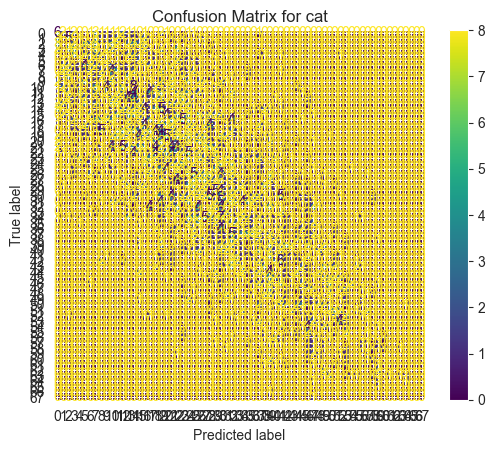

cat Classifier Metrics
Accuracy: 0.0450272142503711
Precision: 0.04683921859561772
Recall: 0.0450272142503711
F1 Score: 0.04452853065444613
Classification Report:
               precision    recall  f1-score   support

        21.0       0.16      0.20      0.18        30
        22.0       0.00      0.00      0.00        28
        23.0       0.03      0.03      0.03        35
        24.0       0.13      0.09      0.11        32
        25.0       0.00      0.00      0.00        26
        26.0       0.00      0.00      0.00        22
        27.0       0.07      0.06      0.06        32
        28.0       0.03      0.03      0.03        34
        29.0       0.07      0.07      0.07        29
        30.0       0.07      0.06      0.06        35
        31.0       0.02      0.02      0.02        41
        32.0       0.05      0.04      0.05        46
        33.0       0.03      0.02      0.03        41
        34.0       0.00      0.00      0.00        41
        35.0       0.04  

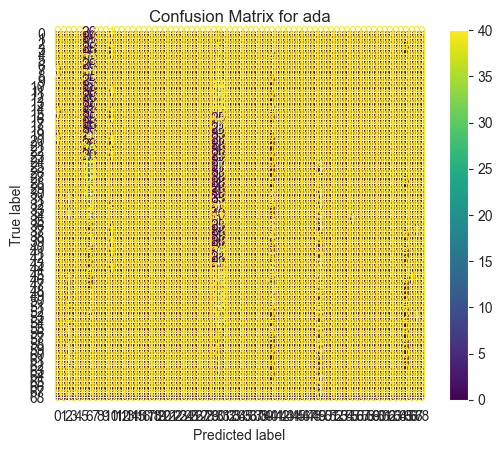

ada Classifier Metrics
Accuracy: 0.0351311232063335
Precision: 0.0022058668914663486
Recall: 0.0351311232063335
F1 Score: 0.004037451072926823
Classification Report:
               precision    recall  f1-score   support

        21.0       0.00      0.00      0.00        30
        22.0       0.00      0.00      0.00        28
        23.0       0.00      0.00      0.00        35
        24.0       0.00      0.00      0.00        32
        25.0       0.00      0.00      0.00        26
        26.0       0.00      0.00      0.00        22
        27.0       0.04      0.81      0.07        32
        28.0       0.00      0.00      0.00        34
        29.0       0.00      0.00      0.00        29
        30.0       0.00      0.00      0.00        35
        31.0       0.00      0.00      0.00        41
        32.0       0.00      0.00      0.00        46
        33.0       0.00      0.00      0.00        41
        34.0       0.00      0.00      0.00        41
        35.0       0.0

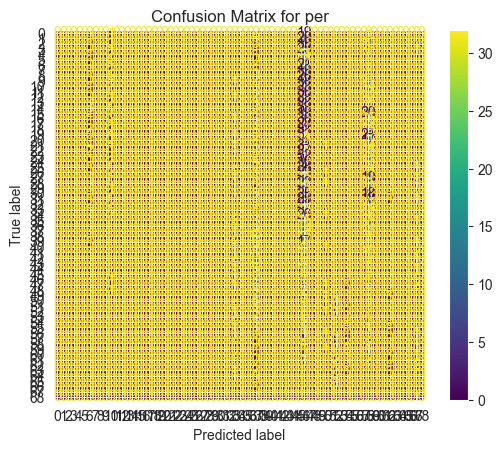

per Classifier Metrics
Accuracy: 0.012864918357248886
Precision: 0.004592816688658951
Recall: 0.012864918357248886
F1 Score: 0.004985114950798452
Classification Report:
               precision    recall  f1-score   support

        21.0       0.00      0.00      0.00        30
        22.0       0.00      0.00      0.00        28
        23.0       0.00      0.00      0.00        35
        24.0       0.00      0.00      0.00        32
        25.0       0.00      0.00      0.00        26
        26.0       0.00      0.00      0.00        22
        27.0       0.00      0.00      0.00        32
        28.0       0.00      0.00      0.00        34
        29.0       0.00      0.00      0.00        29
        30.0       0.00      0.00      0.00        35
        31.0       0.05      0.07      0.06        41
        32.0       0.00      0.00      0.00        46
        33.0       0.00      0.00      0.00        41
        34.0       0.00      0.00      0.00        41
        35.0       

C:\Users\dghr201\.conda\envs\MilestoneI_593\lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning:

Ill-conditioned matrix (rcond=9.0418e-17): result may not be accurate.



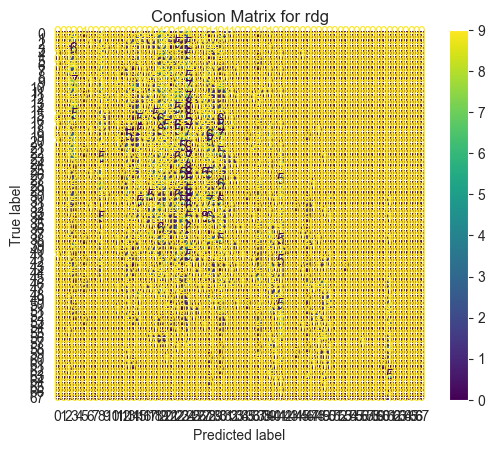

rdg Classifier Metrics
Accuracy: 0.024245423057892134
Precision: 0.01947812581731618
Recall: 0.024245423057892134
F1 Score: 0.01946949121398551
Classification Report:
               precision    recall  f1-score   support

        21.0       0.00      0.00      0.00        30
        22.0       0.00      0.00      0.00        28
        23.0       0.04      0.06      0.04        35
        24.0       0.07      0.19      0.10        32
        25.0       0.00      0.00      0.00        26
        26.0       0.00      0.00      0.00        22
        27.0       0.00      0.00      0.00        32
        28.0       0.00      0.00      0.00        34
        29.0       0.00      0.00      0.00        29
        30.0       0.00      0.00      0.00        35
        31.0       0.00      0.00      0.00        41
        32.0       0.00      0.00      0.00        46
        33.0       0.00      0.00      0.00        41
        34.0       0.04      0.05      0.04        41
        35.0       0.

{'cat': 0.0450272142503711,
 'ada': 0.0351311232063335,
 'per': 0.012864918357248886,
 'rdg': 0.024245423057892134}

In [182]:
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron, RidgeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.preprocessing import LabelBinarizer
import numpy as np

# Create a dictionary to store the models
models = {
    'cat': CatBoostClassifier(task_type="GPU", devices='0:1'),
    'ada': AdaBoostClassifier(),
    'per': Perceptron(),
    'rdg': RidgeClassifier()
}

# Ensure y_test_binarized and y_prob have the same shape
def adjust_binarized_labels(y_bin, y_prob):
    if y_bin.shape[1] != y_prob.shape[1]:
        if y_bin.shape[1] > y_prob.shape[1]:
            # Remove extra columns from y_bin
            y_bin = y_bin[:, :y_prob.shape[1]]
        elif y_bin.shape[1] < y_prob.shape[1]:
            # Add extra columns to y_bin with zeros
            missing_cols = y_prob.shape[1] - y_bin.shape[1]
            y_bin = np.hstack([y_bin, np.zeros((y_bin.shape[0], missing_cols))])
    return y_bin

# Function to evaluate and print metrics
def evaluate_model(y_test, y_pred, y_test_binarized, y_prob, model_name):
    print(f"\n{model_name} Metrics")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    
    # Check if there is more than one class in y_test
    '''if len(set(y_test)) > 1:
        print("ROC AUC:", roc_auc_score(y_test_binarized, y_prob, average='weighted', multi_class='ovr'))
    else:
        print("ROC AUC: Not defined (only one class present in y_true)")'''
    
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Function to compare models
def compare_models(models, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        #y_prob = model.predict_proba(X_test)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)        
        results[name] = accuracy
        print(f"{name}: {accuracy}")
        
        # Generate and plot confusion matrix
        cm = confusion_matrix(y_test, predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f'Confusion Matrix for {name}')
        plt.show()
        
        '''
        # Binarize the output labels
        lb = LabelBinarizer()
        y_test_binarized = lb.fit_transform(y_test)
        
        # Ensure y_test_binarized and y_prob have the same shape
        if y_test_binarized.shape[1] != y_prob.shape[1]:
            y_test_binarized = lb.transform(lb.inverse_transform(y_test_binarized))

        y_test_binarized_model = adjust_binarized_labels(y_test_binarized, y_prob)
        
        # Evaluate CatBoost model
        #evaluate_model(y_test, predictions, y_test_binarized, y_prob, f'{name} Classifier')'''

        
        # Calculating metrics for CatBoost
        
        print(f'{name} Classifier Metrics')
        print("Accuracy:", accuracy_score(y_test, predictions))
        print("Precision:", precision_score(y_test, predictions, average='weighted'))
        print("Recall:", recall_score(y_test, predictions, average='weighted'))
        print("F1 Score:", f1_score(y_test, predictions, average='weighted'))
        #print("ROC AUC:", roc_auc_score(y_test, predictions, average='weighted', multi_class='ovr'))
        #print("ROC AUC:", roc_auc_score(y_test_binarized_model, y_prob, average='weighted', multi_class='ovr'))
        #print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))
        print("Classification Report:\n", classification_report(y_test, predictions))
        
        
    return results

# Run the comparison
compare_models(models, X_train, y_train, X_test, y_test)


### Additional consideration for above classifiers
If I have additional time, I would like to explore the following areas to improve the classifier performance:

class imbalance: If the dataset has class imbalance, I would consider techniques such as oversampling, undersampling, or using class weights to balance the classes and improve the model's performance.